## Orbital Obliquity of Extrasolar Planetary Systems using Random Forest Regression
This Jupyter notebook investigates the orbital obliquity of exoplanets by using a random forest regression machine learning model to build a predictive model to predict the obliquity of an exoplanet based on the properties of the planet itself and host star (the model features). Additionally, I also investigate the correlations and significant of those correlations between obliquity and the properties of a planet and its host star.

Orbital obliquity is the measure of the alignment (i.e., angle) between a planet's orbit (orbital plane/normal) and the equator of its host star (the perpendicular to the spin axis), a quantity also known as spin-orbit alignment (e.g., see, [Rossiter 1924](https://ui.adsabs.harvard.edu/abs/1924ApJ....60...15R/abstract), [McLaughlin 1924](https://ui.adsabs.harvard.edu/abs/1924ApJ....60...22M/abstract), [Queloz et al. 2000](https://ui.adsabs.harvard.edu/abs/2000A%26A...359L..13Q/abstract), [Addison et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...774L...9A/abstract)). A planet's orbit is considered aligned if the measured angle between its orbit and host star equator is consistent with zero degrees. The reason for measuring this exoplanet property is that it provides insights into the formation and evolutionary/migration history of planets (see the review by [Dawson \& Johnson 2018](https://ui.adsabs.harvard.edu/abs/2018ARA%26A..56..175D/abstract)). Obliquity has traditionally been measured via spectroscopy for transiting exoplanets, either by measuring the radial velocity anomaly (a.k.a., the Rossiter-McLaughlin Effect) or the distortion of the stellar line profile, produced during a transit.

Below on the left is an artist impression of the hot Jupiter, WASP-79b, with its orbit misaligned by close to 90 degrees (near polar orbit) and on the right, the Rossiter-McLaughlin Effect velocity anomaly as measured for WASP-79b.
<figure>
    <img src="wasp-79_orbit_full.jpg"
         alt="WASP-79b polar orbit"
         width="495" height="452">
    <img src="radial_velocities.jpg"
         alt="WASP-79b RV anomaly"
         width="486" height="450">
</figure>

Of particular interests are the existence of the so-called 'hot Jupiters', planets with masses and radii similar to that of Jupiter but on orbits well-inside the equivalent orbit of Mercury around the Sun and are therefore, very hot versions of Jupiter. In fact, the most extreme hot Jupiters have orbital periods of less than 1 day! The Solar System obviously does not have a hot Jupiter and their existance is difficult to explain (despite their low occurrence rates). The widely accepted model of planet formation, core-accretion, does not predict the existence of these planets, instead it predicts Jupiter mass planets must form beyond the 'ice-line', about the same distance as Jupiter is from the Sun in the Solar System, where icy volatiles can exist in solid state and can build giant planets. It is thought that hot Jupiters initially formed out beyond the ice-line and then migrated inwards with the process of migration dictating the degree of alignment between the planet's orbit and the host star's equator.

The sample of planet's with measured obliquities has grown in recent years and there are currently nearly 230 planets that have this measurement, see catalog given on [TEPCat](https://www.astro.keele.ac.uk/jkt/tepcat/obliquity.html). The sample size has grown to the point where I believe we can start to really explore potential correlations between the various properties of exoplanets and their host star's with orbital obliquity, which may provide insights into the formation and migration history of exoplanets. In fact, previous studies have shown that there appears to be positive correlation between the effective temperature of the host star and orbital obliquity (first noted by [Winn et al. 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...718L.145W/abstract) and extensively studied by others, e.g., see review by [Albrecht et al. 2022](https://ui.adsabs.harvard.edu/abs/2022PASP..134h2001A/abstract)). One way to probe potential correlations is to use machine learning techniques to develop a model to try to predict orbital obliquity of an exoplanet based on the system's properties (features). To do this, I construct a random forest model from Scikit-learn to train on a portion of the dataset and then predict obliquities on another portion of the dataset that was not trained on. Additionally, I evaluate the performance of my random forest model using a K-fold cross validation technique where I split the dataset into k groups. The model is then evaluated k times, where k-1 groups are used to train each model and one group is used for testing (the testing and training groups are changed at every model evaluation). I also explore a few different ways of handling missing data as well as the steps taken to clean my dataset. Obliquity data comes from the catalogue of the physical properties of transiting planetary systems ([TEPCat](https://www.astro.keele.ac.uk/jkt/tepcat/)) and most of the other planetary and host star properties come from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/).

In [293]:
# Essential Python libraries
import numpy as np
import pandas as pd
import os
import requests
import re
import csv
from datetime import datetime
import itertools
import math

# Astroquery library for querying the astronomical database Simbad
from astroquery.simbad import Simbad

# Pyvo library for accessing TAP based databases (NASA Exoplanet Archive database)
import pyvo as vo

# Matplotlib library for simple plots
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

# Bokeh plotting library and functions
from bokeh.io import output_notebook, show
from bokeh.models.annotations.labels import Label
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, CustomJS, Slider, Whisker, BoxAnnotation, Arrow, OpenHead, Span
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import Legend, LinearAxis, Range1d, ColumnDataSource, LabelSet, HoverTool

# Scikit-learn random forest machine learning library and functions
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

# Other libraries
import scipy.stats as stats
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [2]:
# Download the obliquity dataset from TEPCat

# Exoplanet/host star properties are obtained from NASA's Exoplanet Archive. Given the complexity of the dataset, this should be
# downloaded manually by going to the archive page and selecting the columns required at
# https://exoplanetarchive.ipac.caltech.edu/index.html

current_dir = str(os.getcwd())

req = requests.get("https://www.astro.keele.ac.uk/jkt/tepcat/obliquity.csv")

now = datetime.now() # current date and time
current_date = now.strftime("%d-%m-%Y")

data_input = 'data_input'

if not os.path.exists(current_dir + '/' + data_input):
    os.makedirs(current_dir + '/' + data_input)

# Check if the request was successful
if req.status_code == 200:
    # Save the content to a file
    with open(current_dir + '/' + data_input + "/obliquity_" + current_date + ".csv", "wb") as file:
        file.write(req.content)
    print("Obliquity file downloaded successfully.")
else:
    print("Failed to download the Obliquity file. Status code:", req.status_code)

Obliquity file downloaded successfully.


In [3]:
# Read in the obliquity table.
obliquity_filename = current_dir + '/' + data_input + "/obliquity_" + current_date + ".csv"

# Header is on the first row. The two rows after are comments, so skip.
obliquity_dataframe = pd.read_csv(obliquity_filename, header=0, skiprows=[1,2], low_memory=False)

obliquity_dataframe.head()

,System,Teff,errup,errdn,Pflag,lambda,errup.1,errdn.1,psi,errup.2,errdn.2,Author_string,Ephemeris_reference
0,55_Cnc_e,5172,18,18,n,72.4,12.7,11.5,-999.0,-999.0,-999.0,Bourrier_&amp;_H&eacute;brard_(2014),2014A+A...569A..65B
1,55_Cnc_e,5172,18,18,y,10.0,17.0,20.0,23.0,14.0,12.0,Zhao_et_al._(2023),2023NatAs...7..198Z
2,pi_Men_c,5998,62,62,y,-24.0,4.1,4.1,26.9,5.8,4.7,Hozdic_et_al._(2021),2021MNRAS.502.2893K
3,AU_Mic_b,3540,120,110,y,-4.7,6.8,6.4,-999.0,-999.0,-999.0,Hirano_et_al._(2020),2020ApJ...899L..13H
4,AU_Mic_b,3540,120,110,n,-0.1,5.1,5.0,-999.0,-999.0,-999.0,Martioli_et_al._(2021),2021A+A...649A.177M


In [4]:
# Print the length of the obliquity dataframe. It will be good to know the original length before removing rows.
print('Number of rows in original obliquity table: ', len(obliquity_dataframe))

Number of rows in original obliquity table:  387


In [5]:
# Grab the NASA Exoplanet archive table using the TAP service via pyVO
# This is the preferred way. Note, many tables from the API have been retired.
service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
# Construct the SQL query
my_query = """
SELECT pl_name, default_flag, sy_snum, sy_pnum, discoverymethod, tran_flag,
       pl_controv_flag, cb_flag, pl_refname, pl_orbper, pl_orbpererr1,
       pl_orbpererr2, pl_orbperlim, pl_orbsmax, pl_orbsmaxerr1, pl_orbsmaxerr2, 
       pl_orbsmaxlim, pl_rade, pl_radeerr1, pl_radeerr2, pl_radelim,
       pl_bmassj, pl_bmassjerr1, pl_bmassjerr2, pl_bmassjlim,
       pl_orbeccen, pl_orbeccenerr1, pl_orbeccenerr2, pl_orbeccenlim,
       pl_insol, pl_insolerr1, pl_insolerr2, pl_insollim,
       pl_eqt, pl_eqterr1, pl_eqterr2, pl_eqtlim,
       pl_ratdor, pl_ratdorerr1, pl_ratdorerr2, pl_ratdorlim,
       pl_ratror, pl_ratrorerr1, pl_ratrorerr2, pl_ratrorlim,
       st_refname, st_spectype, st_teff, st_tefferr1, st_tefferr2, st_tefflim,
       st_rad, st_raderr1, st_raderr2, st_radlim,
       st_mass, st_masserr1, st_masserr2, st_masslim,
       st_met, st_meterr1, st_meterr2, st_metlim,
       st_lum, st_lumerr1, st_lumerr2, st_lumlim,
       st_logg, st_loggerr1, st_loggerr2, st_logglim,
       st_age, st_ageerr1, st_ageerr2, st_agelim,
       st_vsin, st_vsinerr1, st_vsinerr2, st_vsinlim,
       st_rotp, st_rotperr1, st_rotperr2, st_rotplim,
       rowupdate
FROM ps
WHERE default_flag = 1 AND tran_flag = 1 AND pl_controv_flag = 0
"""

# Execute the query
resultset = service.search(my_query)

# Convert the result to a pandas DataFrame
planet_prop_dataframe = resultset.to_table().to_pandas()

In [ ]:
###################################Note, run cell above instead of this one########################################

# Grab the NASA Exoplanet archive table using the API service
# This is no longer the preferred way as the API is being phased out in favor of TAP.
# In fact, the table we need, Planetary Systems (PS) is no longer available through the API.

# Base URL for the API
# base_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?"

# # Define the parameters for the API query
# params = {
#     "table": "cumulative",  # Table name (PS table has been retired from the API), cumulative is one of only a few tables
#     # still available. However, this is not what we want.
#     "select": "*",  # Columns to retrieve
#     "format": "csv"  # Output format
# }

# r = requests.get(base_url, params=params)

# if r.status_code == 200:
#     # Read the content directly into a pandas DataFrame
#     from io import StringIO
    
#     # Decode the content and load into DataFrame
#     df = pd.read_csv(StringIO(r.content.decode('utf-8')))
    
#     # Display the first few rows of the DataFrame
#     print(df.head())
# else:
#     print(f"Failed to retrieve data. Status code: {r.status_code}")

In [6]:
# Save the planet properties from the NASA Exoplanet Archive as a csv file in case we need it later.
planet_prop_dataframe.to_csv(current_dir + '/' + data_input + '/NASA_exoplanet_archive_exoplanets_table_' + current_date + '.csv',
                             index=False)

print("CSV file has been created successfully.")

CSV file has been created successfully.


In [ ]:
# Read in the exoplanet/host star property table.
# If you download the planet and stellar properties table from the NASA Exoplanet Archive by hand,
# you can uncomment this block to read in the csv file you downloaded.
# file_creation_date = '16-09-2024'

# planet_prop_filename = current_dir + '/' + data_input + '/NASA_exoplanet_archive_exoplanets_table_' + file_creation_date + '.csv'

# # The first 92 rows are comments, so skip. Header is on row 93.
# #planet_prop_dataframe = pd.read_csv(planet_prop_filename, header=93, low_memory=False)
# planet_prop_dataframe = pd.read_csv(planet_prop_filename, header=0, low_memory=False)

# planet_prop_dataframe.head()

In [7]:
# Print the length of the planet property dataframe. It will be good to know the original length before removing rows.
print('Number of rows in original planet property table from NASA exoplanet archive: ', len(planet_prop_dataframe))

Number of rows in original planet property table from NASA exoplanet archive:  4337


In [205]:
# Next we need to clean up both tables. For example, the planet name given in the obliquity tables has '_' while
# the NASA exoplanet archive table uses spaces. Let's go with spaces for consistency. Also all parameters in the tables
# with numerical values have plus and minus uncertainties. Let's use one value for uncertainties, taking the mean of the
# plus and minus uncertainty for each property.

# Work with the obliquity table first.
obliquity_dataframe_cleaned = obliquity_dataframe.copy(deep=True)
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].str.replace('_', ' ')

# Missing values in the obliquity table are represented as -999.0. Let's replace these with NaN values
obliquity_dataframe_cleaned.replace(-999.0, np.nan, inplace=True)

# Replace errup and errdn for the parameters with err, which is the average between the two values.
obliquity_dataframe_cleaned['Teff_err'] = (abs(obliquity_dataframe_cleaned['errup']) + abs(obliquity_dataframe_cleaned['errdn'])) / 2.0
teff_index = obliquity_dataframe_cleaned.columns.get_loc('Teff') + 1
obliquity_dataframe_cleaned.insert(teff_index, 'Teff_err', obliquity_dataframe_cleaned.pop('Teff_err'))
obliquity_dataframe_cleaned = obliquity_dataframe_cleaned.drop(columns=['errup', 'errdn'])

obliquity_dataframe_cleaned['lambda_err'] = (abs(obliquity_dataframe_cleaned['errup.1']) + abs(obliquity_dataframe_cleaned['errdn.1']))\
                                            / 2.0
lambda_index = obliquity_dataframe_cleaned.columns.get_loc('lambda') + 1
obliquity_dataframe_cleaned.insert(lambda_index, 'lambda_err', obliquity_dataframe_cleaned.pop('lambda_err'))
obliquity_dataframe_cleaned = obliquity_dataframe_cleaned.drop(columns=['errup.1', 'errdn.1'])

obliquity_dataframe_cleaned['psi_err'] = (abs(obliquity_dataframe_cleaned['errup.2']) + abs(obliquity_dataframe_cleaned['errdn.2']))\
                                            / 2.0
psi_index = obliquity_dataframe_cleaned.columns.get_loc('psi') + 1
obliquity_dataframe_cleaned.insert(psi_index, 'psi_err', obliquity_dataframe_cleaned.pop('psi_err'))
obliquity_dataframe_cleaned = obliquity_dataframe_cleaned.drop(columns=['errup.2', 'errdn.2'])

# Finally, drop all the rows where the Pflag column is equal to 'n'. Pflag specifies which values are the accepted values.
obliquity_dataframe_cleaned = obliquity_dataframe_cleaned[obliquity_dataframe_cleaned['Pflag'] != 'n']

obliquity_dataframe_cleaned.reset_index(drop=True, inplace=True)

obliquity_dataframe_cleaned.head()

,System,Teff,Teff_err,Pflag,lambda,lambda_err,psi,psi_err,Author_string,Ephemeris_reference
0,55 Cnc e,5172,18.0,y,10.0,18.5,23.0,13.00,Zhao_et_al._(2023),2023NatAs...7..198Z
1,pi Men c,5998,62.0,y,-24.0,4.1,26.9,5.25,Hozdic_et_al._(2021),2021MNRAS.502.2893K
2,AU Mic b,3540,115.0,y,-4.7,6.6,NaN,NaN,Hirano_et_al._(2020),2020ApJ...899L..13H
3,CoRoT-01,5950,150.0,y,77.0,11.0,NaN,NaN,Pont_et_al._(2010),2010MNRAS.402L...1P
4,CoRoT-02,5598,50.0,y,7.2,4.5,NaN,NaN,Bouchy_et_al._(2008),2008A+A...482L..25B


In [206]:
# Print the length of the obliquity dataframe after dropping rows with Pflag='n'.
print('Number of rows in obliquity table after Pflag="n" drop: ', len(obliquity_dataframe_cleaned))

Number of rows in obliquity table after Pflag="n" drop:  238


In [ ]:
# Print all the rows in the obliquity table to have a closer look. We still need to make some adjustments to the
# System name in order to cross match names with the NASA exoplanet archive table.
print(obliquity_dataframe_cleaned['System'].to_string())

In [207]:
# Function to format the names in the obliquity table.
def format_planet_name(name):
    # Step 1: Remove leading zeros in the numeric part, keeping any existing hyphens correctly
    name = re.sub(r'(\D+)(-?)0+(\d+)', r'\1\2\3', name)

    # Step 2: Add a space before any letter that follows directly after the numeric part
    name = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', name)

    # Step 3: Add ' b' to the end of the name if it does not contain a space followed by a letter
    if not re.search(r'\d [a-zA-Z]', name):
        name += ' b'
    
    return name

In [208]:
# Apply the formatting function to the 'System' column
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].apply(format_planet_name)

#print(obliquity_dataframe_cleaned['System'].to_string())

In [209]:
# Still a few more fixes need to be applied to the planet names. Unfortunately these special cases need manual
# intervention.
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('pi Men c b', 'pi Men c')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('AU Mic b b', 'AU Mic b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('DS Tuc b', 'DS Tuc A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('KELT-19 b', 'KELT-19 A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('TOI-858 B', 'TOI-858 B b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('TOI-1937 b', 'TOI-1937 A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('WASP-77 b', 'WASP-77 A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('WASP-85 b', 'WASP-85 A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('WASP-94 b', 'WASP-94 A b')
obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('WASP-180 b', 'WASP-180 A b')

In [ ]:
# Double check that all the names are in the appropriate format now.
print(obliquity_dataframe_cleaned['System'].to_string())

In [210]:
# The next thing to do is match all of the planet names in the obliquity table with the planet names from the
# NASA Exoplanet Archive Table. The number of matches should equal to the number of rows in the obliquity table
# as all planets in the obliquity table should be in the NASA Exoplanet Archive but obviously not the other way
# around. There might be cases where the name given in the obliquity table does not match the name in the
# Exoplanet archive. We might need to handle these special cases different (hopefully there won't be too many
# of them).
# Determine matching rows based on 'pl_name' in planet_prop_dataframe and 'System' in obliquity_dataframe_cleaned
planets_matched = planet_prop_dataframe[planet_prop_dataframe['pl_name'].isin(obliquity_dataframe_cleaned['System'])]

# Display the matching planets
#print('Planet names in obliqiuty_dataframe_cleaned found in planet_prop_dataframe: ', planets_matched['pl_name'].to_string())
print('Number of planets matched: ', len(planets_matched))

Number of planets matched:  218


In [211]:
# Determine which planets in obliquity_dataframe_cleaned do not match in planet_prop_dataframe.
planets_not_found = obliquity_dataframe_cleaned[~obliquity_dataframe_cleaned['System'].isin(planet_prop_dataframe['pl_name'])]

# Display the planets not found.
print('Planet names in obliqiuty_dataframe_cleaned not found in planet_prop_dataframe: ', planets_not_found['System'].to_string())
print('Number of planets not found: ', len(planets_not_found))

Planet names in obliqiuty_dataframe_cleaned not found in planet_prop_dataframe:  71          K2-93 d
76         K2-234 b
77         K2-267 b
95      Kepler-13 b
100     Kepler-89 d
102    Kepler-420 b
103    Kepler-448 b
130      TOI-2031 b
133      TOI-2485 b
135      TOI-2533 b
138      TOI-3972 b
176       WASP-30 b
213      WASP-109 b
214      WASP-111 b
218      WASP-122 b
222      WASP-134 b
234          XO-2 b
Number of planets not found:  17


In [212]:
# As per usual in Astronomy, the host stars have been given many different names and there is no agreeable
# 'preferred' name. As such, the planets in the obliquity table that were not found in the planet property
# table are due to a different name being used. To be completely robust, the best way to proceed is to
# query simbad of all the planets that did not match to retrieve all the possible names for the host star
# and then search the planet property table for a match. If a match is found, change the name to the one
# that is matched.
# Examples of ones that didn't match but are under a different name:
# K2-93 d is given as HIP 41378 d
# K2-234 b is given as HD 89345 b
# K2-267 b is given as EPIC 246851721 b
# Kepler-13 b is given as KOI-13 b
# Kepler-89 b is given as KOI-94 b

# Create a function to query Simbad for all of the possible names for a given host star.
# We will then use this to cross-match with the planet properties table.
def query_simbad_for_names(host_star):
    """
    Query Simbad for possible names associated with the given host star name.
    """
    try:
        # Query Simbad to get all known names for the host star
        result = Simbad.query_objectids(host_star)

        if result is not None:
            all_names = result
            return all_names
        else:
            return []
        
    except Exception as e:
        print(f"Error querying {host_star}: {e}")
        return []

In [213]:
# Ensure the correct VOTable parsing (in case there's a change in Simbad's backend response format)
Simbad.TIMEOUT = 300

# List to store names updated for reporting
updated_names = []

# Iterate over non-matching rows in obliquity_dataframe_cleaned. Then query simbad for all possible names.
# Then iterate over those names and see if any match the names in the planet properties table.
# If there is a match, replace the name in the obliquity table.
for index, row in planets_not_found.iterrows():
    system_name = row['System']
    
    # Prepare base name for querying (remove last letter and space)
    host_star = system_name.rsplit(' ', 1)[0]
    
    # Query Simbad for alternative names
    #print('host_star: ', host_star)
    alternative_names = query_simbad_for_names(host_star)

    #print('alternative_names: ', alternative_names)
    
    # Search for matching names in planet_prop_dataframe
    found_match = False
    for name in alternative_names:
        # Add the last letter back to the name for searching. Also remove leading and trailing whitespace.
        possible_name = f"{name[0].strip()} {system_name[-1]}"
        #Annoyingly, some names from Simbad have multiple whitespace. Remove that whitespace.
        possible_name = re.sub(' +', ' ', possible_name)
        #print('possible_name: ', possible_name)
        
        # Check if the modified name exists in planet_prop_dataframe['pl_name']
        if possible_name in planet_prop_dataframe['pl_name'].values:
            # Update the name in obliquity_dataframe_cleaned
            obliquity_dataframe_cleaned.at[index, 'System'] = possible_name
            updated_names.append((system_name, possible_name))  # Store the update
            found_match = True
            break  # No need to continue if a match is found

    if len(alternative_names)==0:
        print(f"No match found in Simbad for {system_name}")
    elif not found_match and len(alternative_names)>0:
        print(f"No names in Simbad matched NASA Exoplanet table for {system_name}")

# Display updated names for verification
print("Updated Names in obliquity_dataframe_cleaned:")
for original, updated in updated_names:
    print(f"{original} -> {updated}")

No names in Simbad matched NASA Exoplanet table for TOI-2031 b
No names in Simbad matched NASA Exoplanet table for TOI-2485 b
No names in Simbad matched NASA Exoplanet table for TOI-2533 b
No names in Simbad matched NASA Exoplanet table for TOI-3972 b
No names in Simbad matched NASA Exoplanet table for WASP-30 b
No names in Simbad matched NASA Exoplanet table for WASP-109 b
No names in Simbad matched NASA Exoplanet table for WASP-111 b
No names in Simbad matched NASA Exoplanet table for WASP-134 b
No names in Simbad matched NASA Exoplanet table for XO-2 b
Updated Names in obliquity_dataframe_cleaned:
K2-93 d -> HIP 41378 d
K2-234 b -> HD 89345 b
K2-267 b -> EPIC 246851721 b
Kepler-13 b -> KOI-13 b
Kepler-89 d -> KOI-94 d
Kepler-420 b -> KOI-1257 b
Kepler-448 b -> KOI-12 b
WASP-122 b -> KELT-14 b


In [214]:
# Let's check the matches again after the name changes
planets_matched_new = planet_prop_dataframe[planet_prop_dataframe['pl_name'].isin(obliquity_dataframe_cleaned['System'])]

# Display the matching planets
#print('Planet names in obliqiuty_dataframe_cleaned found in planet_prop_dataframe: ', planets_matched_new['pl_name'].to_string())
print('Number of planets matched: ', len(planets_matched_new))

Number of planets matched:  226


In [215]:
# Check the ones that didn't match again.
planets_not_found_new = obliquity_dataframe_cleaned[~obliquity_dataframe_cleaned['System'].isin(planet_prop_dataframe['pl_name'])]

# Display the planets not found.
print('Planet names in obliqiuty_dataframe_cleaned not found in planet_prop_dataframe: ', planets_not_found_new['System'].to_string())
print('Number of planets not found: ', len(planets_not_found_new))

Planet names in obliqiuty_dataframe_cleaned not found in planet_prop_dataframe:  130    TOI-2031 b
133    TOI-2485 b
135    TOI-2533 b
138    TOI-3972 b
176     WASP-30 b
213    WASP-109 b
214    WASP-111 b
222    WASP-134 b
234        XO-2 b
Number of planets not found:  9


In [216]:
# A search by hand for the planets not matched reveals most of them are not in the NASA Exoplanet Archive or
# are brown dwarfs, so technically not planets. However, I did find that XO-2 b is actually named XO-2 N b
# in the NASA Exoplanet Archive, so I update the name in the obliquity table.

obliquity_dataframe_cleaned['System'] = obliquity_dataframe_cleaned['System'].replace('XO-2 b', 'XO-2 N b')

# Let's check the matches again after the name changes
planets_matched_new = planet_prop_dataframe[planet_prop_dataframe['pl_name'].isin(obliquity_dataframe_cleaned['System'])]

# Display the matching planets
print('Number of planets matched: ', len(planets_matched_new))

Number of planets matched:  227


In [217]:
# Now we need to select the columns from the obliquity and planet property tables that we want to keep for the
# planets in the obliquity table that match with the corresponding planets in the planet property table. For this,
# we will create a new dataframe that will hold all the data we need.
columns_from_obliquity = ['System', 'Teff', 'Teff_err', 'lambda', 'lambda_err', 'psi', 'psi_err', 'Ephemeris_reference']
columns_from_planet_prop = ['sy_snum', 'sy_pnum', 'cb_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
                            'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_bmassj',
                            'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_insol',
                            'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_ratdor', 'pl_ratdorerr1',
                            'pl_ratdorerr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'st_refname', 'st_spectype',
                            'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_mass',
                            'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_lum', 'st_lumerr1',
                            'st_lumerr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_age', 'st_ageerr1', 'st_ageerr2',
                            'st_vsin', 'st_vsinerr1', 'st_vsinerr2', 'st_rotp', 'st_rotperr1', 'st_rotperr2', 'rowupdate']

# Merge dataframes on matching 'System' and 'pl_name'
merged_df = pd.merge(
    obliquity_dataframe_cleaned[columns_from_obliquity],  # Include 'System' for merging
    planet_prop_dataframe[columns_from_planet_prop + ['pl_name']],  # Include 'pl_name' for merging
    left_on='System', 
    right_on='pl_name'
)

# Drop the redundant 'pl_name' column as it's now the same as 'System'
merged_df.drop(columns=['pl_name'], inplace=True)

# Create the new dataframe
planet_obliquity_prop_dataframe = merged_df

In [218]:
# Let's check the merged dataframe. Specifically the length (should match the number of rows in
# obliquity_dataframe_cleaned) and the columns.

print('Length of merged table: ', len(planet_obliquity_prop_dataframe))
#print(planet_obliquity_prop_dataframe.iloc[0].to_string())
#print('First row of merged table: ', planet_obliquity_prop_dataframe[0])

Length of merged table:  230


In [219]:
# Now we need to clean the merged table. Specifically, we use the mean of the plus and minus uncertainty for
# each property to simplify the analysis. For many properties, if an uncertainty is not given, it means the
# the value given is the upper limit and the uncertainty should be equal to the value given (e.g., if a planet
# mass of 0.1Mjup is given without an uncertainty, then the uncertainty should be set to 0.1Mjup, as a mass
# greater than 0.1Mjup would have been above the detection threshold). Both the obliquity and planet property
# tables have the stellar effective temperature. The planet property table from the NASA Exoplanet Archive should
# have the most up-to-date value for this parameter, so we should use it instead of the one provided in the
# obliquity table. The exception being for cases where Teff is given in the obliquity table but not in the
# planet property table.

planet_obliquity_prop_dataframe_cleaned = planet_obliquity_prop_dataframe.copy(deep=True)

# Let's create a function to combine the uncertainties.
# Combine st_teff and Teff values into one column. If null values exist for the column st_teff (originally from
# the planet property table), take the Teff value instead (originally in the obliquity table).
# planet_obliquity_prop_dataframe_cleaned['st_teff'] = planet_obliquity_prop_dataframe_cleaned['st_teff'].combine_first(
#                                                         planet_obliquity_prop_dataframe_cleaned['Teff'])

# First deal with the effective temperature as described above. Note errors should always be positive values.
def calculate_teff_teff_err(row):
    if np.isnan(row['st_teff']) and not np.isnan(row['Teff']):
        # Return both Teff and Teff_err from original obliquity table.
        return row['Teff'], row['Teff_err']
    elif not np.isnan(row['st_teff']):
        # If st_teff is not null, we will use st_teff and now deal with the upper and lower errors.
        if not np.isnan(row['st_tefferr1']) and not np.isnan(row['st_tefferr2']):
            # Return st_teff and the mean of st_tefferr1 and st_tefferr2 as both are not null.
            return row['st_teff'], (abs(row['st_tefferr1']) + abs(row['st_tefferr2'])) / 2.0
        elif not np.isnan(row['st_tefferr1']):
            # Return st_teff and use st_tefferr1 if st_tefferr2 is null.
            return row['st_teff'], abs(row['st_tefferr1'])
        elif not np.isnan(row['st_tefferr2']):
            # Return st_teff and use st_tefferr2 if st_tefferr1 is NaN.
            return row['st_teff'], abs(row['st_tefferr2'])
        elif np.isnan(row['st_tefferr1']) and np.isnan(row['st_tefferr2']) and not np.isnan(row['Teff_err']):
            # If both st_tefferr1 and st_tefferr2 are null while Teff_err is not null, then use the
            # effective temperature and error from the original obliquity table.
            return row['Teff'], row['Teff_err']
        else:
            # Return st_teff and use st_teff as the error for st_tefferr1, st_tefferr2, and Teff_err are null.
            return row['st_teff'], abs(row['st_teff'])
    else:
        return np.nan, np.nan

# Apply function to determine st_teff and st_teff_err
teff_results = planet_obliquity_prop_dataframe_cleaned.apply(calculate_teff_teff_err, axis=1, result_type='expand')

# Update st_teff with new values
planet_obliquity_prop_dataframe_cleaned['st_teff'] = teff_results[0]

# Insert st_teff_err right after st_teff column
st_teff_index = planet_obliquity_prop_dataframe_cleaned.columns.get_loc('st_teff')
planet_obliquity_prop_dataframe_cleaned.insert(st_teff_index + 1, 'st_teff_err', teff_results[1])

# Drop the old columns that are no longer needed
planet_obliquity_prop_dataframe_cleaned.drop(columns=['Teff', 'Teff_err', 'st_tefferr1', 'st_tefferr2'], inplace=True)

# Display the updated dataframe
print(planet_obliquity_prop_dataframe_cleaned.head())

# Double check that the effective temperatures and uncertainties are as expected.
# for row in range(len(planet_obliquity_prop_dataframe_cleaned)):
#     print('System: ', planet_obliquity_prop_dataframe_cleaned.loc[row, 'System'],
#           'Teff: ', planet_obliquity_prop_dataframe.loc[row, 'Teff'],
#           'Teff_err: ', planet_obliquity_prop_dataframe.loc[row, 'Teff_err'],
#           'st_teff: ', planet_obliquity_prop_dataframe_cleaned.loc[row, 'st_teff'],
#           'st_teff_err: ', planet_obliquity_prop_dataframe_cleaned.loc[row, 'st_teff_err'])

      System  lambda  lambda_err   psi  psi_err  Ephemeris_reference  sy_snum  \
0   55 Cnc e    10.0        18.5  23.0    13.00  2023NatAs...7..198Z        2   
1   pi Men c   -24.0         4.1  26.9     5.25  2021MNRAS.502.2893K        1   
2   AU Mic b    -4.7         6.6   NaN      NaN  2020ApJ...899L..13H        1   
3  CoRoT-1 b    77.0        11.0   NaN      NaN  2010MNRAS.402L...1P        1   
4  CoRoT-2 b     7.2         4.5   NaN      NaN  2008A+A...482L..25B        2   

   sy_pnum  cb_flag                                         pl_refname  ...  \
0        5        0  <a refstr=BOURRIER_ET_AL__2018 href=https://ui...  ...   
1        3        0  <a refstr=FENG_ET_AL__2022 href=https://ui.ads...  ...   
2        3        0  <a refstr=CALE_ET_AL__2021 href=https://ui.ads...  ...   
3        1        0  <a refstr=BARGE_ET_AL__2008 href=https://ui.ad...  ...   
4        1        0  <a refstr=GILLON_ET_AL__2010 href=https://ui.a...  ...   

   st_age  st_ageerr1  st_ageerr2  st_

In [220]:
# Create another function to deal with the uncertainties for the other parameters. Errors should always be positive.
def calculate_err(row, base_col):
    # If the two error columns are not null, calculate the average between them.
    if not np.isnan(row[base_col + 'err1']) and not np.isnan(row[base_col + 'err2']):
        # Return The mean of the two error columns as they are not null.
        return (abs(row[base_col + 'err1']) + abs(row[base_col + 'err2'])) / 2.0
    elif not np.isnan(row[base_col + 'err1']):
        # Return the upper error column as it is not null.
        return abs(row[base_col + 'err1'])
    elif not np.isnan(row[base_col + 'err2']):
        # Return the lower error column as it is not null.
        return abs(row[base_col + 'err2'])
    elif not np.isnan(row[base_col]) and np.isnan(row[base_col + 'err1']) and np.isnan(row[base_col + 'err2']):
        # Return the value for the base column as the error as the upper and lower errrors are null, assuming
        # the value in the base column is not null.
        return abs(row[base_col])
    else:
        # If everything is null, then return null.
        return np.nan

# Apply the above function to the other columns.
base_cols = ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_ratdor', 'pl_ratror',
             'st_rad', 'st_mass', 'st_met', 'st_lum', 'st_logg', 'st_age', 'st_vsin', 'st_rotp']
for base_col in base_cols:
    # Apply the function and create a new error column for each base column
    error_values = planet_obliquity_prop_dataframe_cleaned.apply(
        lambda row: calculate_err(row, base_col), axis=1
    )
    
    # Determine the position of the base column to insert the new error column next to it
    base_col_index = planet_obliquity_prop_dataframe_cleaned.columns.get_loc(base_col)
    
    # Insert the new error column next to the base column
    planet_obliquity_prop_dataframe_cleaned.insert(
        base_col_index + 1, base_col + '_err', error_values
    )

    # planet_obliquity_prop_dataframe_cleaned[base_col + '_err'] = planet_obliquity_prop_dataframe_cleaned.apply(
    #     lambda row: calculate_err(row, base_col), axis=1
    # )

# Drop the old columns that are no longer needed after adjusting errors.
err_columns_to_drop = [col + 'err1' for col in base_cols] + [col + 'err2' for col in base_cols]
planet_obliquity_prop_dataframe_cleaned.drop(columns=err_columns_to_drop, inplace=True)

# Obliquities should be given on an absolute scale from 0 to 180 deg, where 0 deg is a prograde orbit,
# 90 deg is a polar orbit, and 180 deg is a retrograde orbit.
def adjust_angle(angle):
    if 0 <= angle <= 180:
        return angle  # Keep as is
    elif -180 <= angle < 0:
        return abs(angle)  # Take the absolute value
    elif -360 <= angle < -180:
        return 360 + angle  # Shift by adding 360 to bring within range
    elif 180 < angle <= 360:
        return 360 - angle  # Shift by subtracting the angle from 360
    else:
        return angle  # In case of unexpected values, return as is

planet_obliquity_prop_dataframe_cleaned['lambda'] = planet_obliquity_prop_dataframe_cleaned['lambda'].apply(adjust_angle)
planet_obliquity_prop_dataframe_cleaned['psi'] = planet_obliquity_prop_dataframe_cleaned['psi'].apply(adjust_angle)

print(planet_obliquity_prop_dataframe_cleaned.head())

      System  lambda  lambda_err   psi  psi_err  Ephemeris_reference  sy_snum  \
0   55 Cnc e    10.0        18.5  23.0    13.00  2023NatAs...7..198Z        2   
1   pi Men c    24.0         4.1  26.9     5.25  2021MNRAS.502.2893K        1   
2   AU Mic b     4.7         6.6   NaN      NaN  2020ApJ...899L..13H        1   
3  CoRoT-1 b    77.0        11.0   NaN      NaN  2010MNRAS.402L...1P        1   
4  CoRoT-2 b     7.2         4.5   NaN      NaN  2008A+A...482L..25B        2   

   sy_pnum  cb_flag                                         pl_refname  ...  \
0        5        0  <a refstr=BOURRIER_ET_AL__2018 href=https://ui...  ...   
1        3        0  <a refstr=FENG_ET_AL__2022 href=https://ui.ads...  ...   
2        3        0  <a refstr=CALE_ET_AL__2021 href=https://ui.ads...  ...   
3        1        0  <a refstr=BARGE_ET_AL__2008 href=https://ui.ad...  ...   
4        1        0  <a refstr=GILLON_ET_AL__2010 href=https://ui.a...  ...   

   st_lum_err  st_logg  st_logg_err  s

In [221]:
# At this point, it is probably worth writing out the merged obliquity and planet/stellar properties
# dataframe as a CSV file. I find it easier sometimes to visually inspect in Excel.
merged_dataframe_filename_out = current_dir + '/' + data_input + '/merged_obliquity_planet_stellar_properties_' + current_date + '.csv'
planet_obliquity_prop_dataframe_cleaned.to_csv(merged_dataframe_filename_out, index=False)

# Initial data exploration, cleaning, missing values and imputing, visualisation, and feature engineering
The following cells will explore this dataset further through a series of plots. In some cases, the dataset will need
further cleaning. Additionally, we will some way of dealing with columns with lots of missing data. In some cases,
these columns will be of little value so we might end up dropping them. In other cases, we will need to impute missing
values with something that makes sense (e.g., set to 0 or set to the median value). Lastly we will look at the relationships
between the various parameters and the orbital obliquity. We will also need to figure out how to handle systems where
the true obliquity (psi) is given (as opposed to just the projected obliquity, lambda), as we are ultimately
interested in the true obliquity but this parameter is not known for most systems. Maybe planets with psi known
should be given a larger weight? In the final step, we will attempt to build a predictive model to determine
the obliquity of a given system (or at least whether a planet's orbit should be aligned or misaligned).

In [ ]:
# # If you have run the above steps before and would like to read in the merged and cleaned dataframe from the
# # saved csv file, uncomment the following lines.
# current_dir = str(os.getcwd())
# file_creation_date = '18-09-2024'
# data_input = 'data_input'

# merged_prop_filename = current_dir + '/' + data_input + '/merged_obliquity_planet_stellar_properties_' + file_creation_date + '.csv'

# planet_obliquity_prop_dataframe_cleaned = pd.read_csv(merged_prop_filename, header=0, low_memory=False)

# planet_obliquity_prop_dataframe_cleaned.head()

In [ ]:
# Let's get some basic info on the columns of the merged table. We will drop some of the columns that we won't need
# for the analysis.
print(planet_obliquity_prop_dataframe_cleaned.info())

In [ ]:
# Let's get some basic statistics of these columns.
for col in planet_obliquity_prop_dataframe_cleaned.columns:
    print('column: ', col)
    print(planet_obliquity_prop_dataframe_cleaned[col].describe())

In [222]:
# It looks like there are a couple of systems with more than one entry. Let's find duplicate entries.
duplicates = planet_obliquity_prop_dataframe_cleaned[planet_obliquity_prop_dataframe_cleaned.duplicated(['System'],
                                                                                                        keep=False)]
duplicate_planets = planet_obliquity_prop_dataframe_cleaned[planet_obliquity_prop_dataframe_cleaned['System'].duplicated(keep='first')]
duplicate_planets = duplicate_planets['System']

# Print these rows. There are not too many of them. We will need to decide which ones to keep.
for row in range(len(duplicates)):
    print(duplicates.iloc[row])

System                                                         WASP-47 b
lambda                                                               0.0
lambda_err                                                          24.0
psi                                                                  NaN
psi_err                                                              NaN
Ephemeris_reference                                  2015ApJ...812L..11S
sy_snum                                                                1
sy_pnum                                                                4
cb_flag                                                                0
pl_refname             <a refstr=NASCIMBENI_ET_AL__2023 href=https://...
pl_orbper                                                       4.159151
pl_orbper_err                                                        0.0
pl_orbsmax                                                           NaN
pl_orbsmax_err                                     

In [223]:
# I think the best approach is to keep entries with the latest obliquity measurement, as given by the year in the
# Ephemeris_reference column (first four numbers in the string).

# Function to extract the year from 'Ephemeris_reference' if it is in the correct format
def extract_year(ref):
    if isinstance(ref, str) and len(ref) >= 4 and ref[:4].isdigit():
        return int(ref[:4])
    else:
        return None

# Create a new 'Year' column with the extracted year or None if invalid
planet_obliquity_prop_dataframe_cleaned['Year'] = planet_obliquity_prop_dataframe_cleaned['Ephemeris_reference'].apply(extract_year)

#print(planet_obliquity_prop_dataframe_cleaned)

# Separate rows with valid and invalid 'Ephemeris_reference'
valid_year = planet_obliquity_prop_dataframe_cleaned.dropna(subset=['Year']).copy(deep=True)
invalid_year = planet_obliquity_prop_dataframe_cleaned[planet_obliquity_prop_dataframe_cleaned['Year'].isna()].copy(deep=True)
#print('invalid_year: ', invalid_year)

# Sort valid entries by 'System' and 'Year' in descending order
valid_year.sort_values(by=['System', 'Year'], ascending=[True, False], inplace=True)
#print('valid_year1: ', valid_year['System'].to_list())

# Drop duplicates, keeping the first occurrence (most recent year)
valid_year = valid_year.drop_duplicates(subset='System', keep='first')
valid_year.sort_index(inplace=True)
#print('valid_year2: ', valid_year['System'].to_list())

# Combine valid and invalid entries back together.
planet_obliquity_prop_dataframe_cleaned = pd.concat([valid_year, invalid_year], ignore_index=True)

# Drop the 'Year' column
planet_obliquity_prop_dataframe_cleaned.drop(columns=['Year'], inplace=True)

#print(planet_obliquity_prop_dataframe_cleaned)

# filename_out = current_dir + '/obliquity_planet_stellar_properties_test_' + current_date + '.csv'
# planet_obliquity_prop_dataframe_cleaned.to_csv(filename_out, index=True)

In [224]:
# Check to make sure the correct planet entries were kept.
for duplicate in duplicate_planets:
    print(planet_obliquity_prop_dataframe_cleaned[planet_obliquity_prop_dataframe_cleaned['System']==duplicate])

        System  lambda  lambda_err   psi  psi_err  Ephemeris_reference  \
163  WASP-47 b     NaN         NaN  29.0     12.0  2023A+A...669A..63B   

     sy_snum  sy_pnum  cb_flag  \
163        1        4        0   

                                            pl_refname  ...  st_lum_err  \
163  <a refstr=NASCIMBENI_ET_AL__2023 href=https://...  ...         NaN   

     st_logg  st_logg_err  st_age  st_age_err  st_vsin  st_vsin_err  st_rotp  \
163      NaN          NaN     NaN         NaN      NaN          NaN      NaN   

     st_rotp_err   rowupdate  
163          NaN  2024-08-16  

[1 rows x 49 columns]
         System  lambda  lambda_err    psi  psi_err  Ephemeris_reference  \
188  WASP-107 b   158.0        17.0  103.5    1.795  2023A+A...669A..63B   

     sy_snum  sy_pnum  cb_flag  \
188        1        2        0   

                                            pl_refname  ...  st_lum_err  \
188  <a refstr=PIAULET_ET_AL__2021 href=https://ui....  ...        0.01   

     st_logg

In [225]:
# Some columns to drop include the reference columns and update column.
# We might also consider dropping a few other columns which we will not want to build a model on.
# Dropping 'cb_flag' (circumbinary flag) as all values are 0, i.e., no planets in table are circumbinary planets.
# In the future, we might need to keep this column if any circumbinary planets have measured obliquities though
# this is probably unlikely.
col_drop = ['Ephemeris_reference', 'pl_refname', 'st_refname', 'rowupdate', 'cb_flag']
planet_obliquity_prop_dataframe_model = planet_obliquity_prop_dataframe_cleaned.copy(deep=True)
planet_obliquity_prop_dataframe_model.drop(columns=col_drop, inplace=True)

In [226]:
# Let's create some exploratory plots by defining plot functions.
def errorbar(fig, x, y, xerr=None, yerr=None, color='red', label=None,
             error_kwargs={}):

    """
    Function to plot x-y uncertainties.
    
    Parameters
    ----------
    fig : bokeh plotting object
        The bokeh plotting object to plot the uncertainties on.
    x : list or series
        The x axis data to apply uncertainties.
    y : list or series
        The y axis data to apply uncertainties.

    Optional
    --------
    xerr : list or series
        The uncertainties on the x axis data.
        Default: None
    yerr : list or series
        The uncertainties on the y axis data.
        Default: None
    color : string or list
        A string or list of colors to use for plotting the error bars.
        Default: 'red'
    label : string
        The labels to assign the data.
        Default: None
    error_kwargs : string or list
        Additional key words related to the errorbar plotting.
        Default: {}

    Returns
    -------
    Error bars added to plot.
    """

    if xerr is not None:
        x_err_x = []
        x_err_y = []

        if isinstance(x, (np.floating, float)):
            x_err_x.append((x - xerr, x + xerr))
            x_err_y.append((y, y))
        else:
            for px, py, err in zip(x, y, xerr):
                x_err_x.append((px - err, px + err))
                x_err_y.append((py, py))
        fig.multi_line(x_err_x, x_err_y, color=color, line_width=3.0, legend_label=label, **error_kwargs)

    if yerr is not None:
        y_err_x = []
        y_err_y = []
        if isinstance(y, (np.floating, float)):
            y_err_x.append((x, x))
            y_err_y.append((y - yerr, y + yerr))
        else:
            for px, py, err in zip(x, y, yerr):
                y_err_x.append((px, px))
                y_err_y.append((py - err, py + err))
        fig.multi_line(y_err_x, y_err_y, color=color, line_width=3.0, legend_label=label, **error_kwargs)

def explore_plots(x_axis_data, y_axis_data, x_axis_label, y_axis_label, title, system_names, p=None, color_plot=['black'],
                  label=None, symbols='asterisk', x_axis_data_err=None, y_axis_data_err=None, color_err=['red'],
                  xscale='linear', yscale='linear'):

    """
    Function to create plots.
    
    Parameters
    ----------
    x_axis_data : list or series
        The x axis data to plot.
    y_axis_data : list or series
        The y axis data to plot.
    x_axis_label : string
        The label to use for the x axis.
    y_axis_label : string
        The label to use for the y axis.
    title : string
        The title for the plot.
    system_names : list or series
        The system names corresponding to each point.

    Optional
    --------
    p : bokeh plotting object
        A bokeh plotting object to add additional plotting objects to.
        Default: None
    color_plot : string or list
        A string or list of colors to use for plotting the data. . If list, must be length of number of data points.
        Default: ['black']
    label : string
        The labels to assign all the data point.
        Default: None
    symbols : string or list
        The plotting markers for the data.
        Default: 'asterisk'
    x_axis_data_err : list or series
        The uncertainties on the x axis data.
        Default: None
    y_axis_data_err : list or series
        The uncertainties on the y axis data.
        Default: None
    color_err : string or list
        A string or list of colors to use for plotting the error bars. If list, must be length of number of data points.
        Default: ['red']
    xscale : string
        A string indicating the scaling to use along the x axis, e.g., linear or log.
        Default: 'linear'
    yscale : string
        A string indicating the scaling to use along the y axis, e.g., linear or log.
        Default: 'linear'

    Returns
    -------
    p : bokeh object
        The Bokeh plotting object.
    """

    colors={'violet':'#6E36BB','pink':'#D8BAFF','blue':'#2480D0','cyan':'#00E6E6','green':'#1DD14B',
            'yellow':'#FFD700','orange':'#FF6600','dorange':'#DAA520','red':'#DD082C','black':'#000000',
            'grey':'#D0D0D0','dgrey':'#666666'}

    # Create a ColumnDataSource with the data and system names
    source = ColumnDataSource(data={
        'x': x_axis_data,
        'y': y_axis_data,
        'system': system_names,
        'xerr': x_axis_data_err if x_axis_data_err is not None else [0] * len(x_axis_data),
        'yerr': y_axis_data_err if y_axis_data_err is not None else [0] * len(y_axis_data)
    })

    if p is None:
        p = figure(title=title, height=1000, width=1500, x_axis_type=xscale, y_axis_type=yscale,
                   tools="reset, hover, zoom_in, zoom_out, box_zoom, wheel_zoom, pan, save")
    
        p.add_layout(Legend(), 'right')

        p.title.text_font_size = '20pt'
        p.yaxis.axis_label = y_axis_label
        p.xaxis.axis_label_text_font_size = "20pt"
        p.xaxis.major_label_text_font_size = "20pt"
        p.xaxis.axis_label_text_font = "times"
        p.xaxis.axis_label_text_color = "black"
        p.xaxis.major_tick_in = 10
        p.xaxis.major_tick_out = 0
        p.xaxis.minor_tick_in = 4
        p.xaxis.minor_tick_out = 0
        p.xaxis.major_tick_line_width = 2
        p.xaxis.axis_label = x_axis_label
        p.yaxis.axis_label_text_font_size = "20pt"
        p.yaxis.major_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font = "times"
        p.yaxis.axis_label_text_color = "black"
        p.yaxis.major_tick_in = 10
        p.yaxis.major_tick_out = 0
        p.yaxis.minor_tick_in = 4
        p.yaxis.minor_tick_out = 0
        p.yaxis.major_tick_line_width = 2

        p.legend.click_policy="hide"

    if isinstance(color_plot, list): 
        color_plot_values = [colors[c] for c in color_plot]
    else:
        color_plot_values = colors[color_plot]
    if  isinstance(color_err, list): 
        color_err_values = [colors[c] for c in color_err]
    else:
        color_err_values = colors[color_err]

    scatter_renderer = p.scatter('x', 'y', source=source, size=8, marker=symbols, color=color_plot_values, alpha=0.5,
                                 legend_label=label)
    
    errorbar(p, x_axis_data, y_axis_data, xerr=x_axis_data_err, yerr=y_axis_data_err, color=color_err_values,
             label=label, error_kwargs={'alpha':0.5})

    # Create a hover tool and attach it only to the scatter renderer
    hover = HoverTool(renderers=[scatter_renderer], tooltips=[("System", "@system"), ("x", "@x"), ("y", "@y")])
    p.add_tools(hover)

    return p

In [227]:
# Create some exploratory plots.

direct_out = current_dir + '/exploratory_plots'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

# Let's start by creating a plot of stellar effective temperature vs obliquity. It has been widely reported
# in the literature that there is a strong correlation between the effective temperature of the host star
# and the degree of spin-orbit misalignment. Planets orbiting hot stars above the Kraft Break (~6250K) tend
# to show spin-orbit misalignment versus planets orbiting cooler stars which are predominately in
# spin-orbit alignment. The reason for this appears to be that hot stars do no have a convective envelope
# and a star with a convective envelope will realign a planets orbit much quicker through tidal interactions
# than stars that have a radiative envelope. We should explore this correlation first.
filename = current_dir + '/exploratory_plots' + '/temperature_vs_obliquity.html'

x_axis_label = r"$$\mathrm{Stellar\ Effective\ Temperature\ T_{Eff}\ (K)}$$"
y_axis_label = r"$$\mathrm{Orbital\ Obliquity\ |\lambda|\ or\ |\psi|\ (deg)}$$"
title = "Stellar effective temperature vs orbital obliquity"

# Grab the obliquity data from the column lambda unless a value is given in the column psi.
# Recall, lambda is the projected obliquity while psi is the true obliquity. True obliquity
# is preferred as the projected obliquity could potentially be very different from the true
# obliquity.

# Split the data between projected and true obliquity.
x_data_lambda = []
x_data_lambda_err = []
x_data_psi = []
x_data_psi_err = []
y_data_lambda = []
y_data_lambda_err = []
y_data_psi = []
y_data_psi_err = []

# Iterate over each row of the DataFrame
for index, row in planet_obliquity_prop_dataframe_model.iterrows():
    if pd.notna(row['psi']):  # If 'psi' has a value
        x_data_psi.append(row['st_teff'])
        x_data_psi_err.append(row['st_teff_err'])
        y_data_psi.append(row['psi'])
        y_data_psi_err.append(row['psi_err'])
    else:  # If 'psi' is NaN, use 'lambda' value
        x_data_lambda.append(row['st_teff'])
        x_data_lambda_err.append(row['st_teff_err'])
        y_data_lambda.append(row['lambda'])
        y_data_lambda_err.append(row['lambda_err'])

# Convert y_data to a pandas Series
x_data_psi = pd.Series(x_data_psi)
x_data_psi_err = pd.Series(x_data_psi_err)
y_data_psi = pd.Series(y_data_psi)
y_data_psi_err = pd.Series(y_data_psi_err)
x_data_lambda = pd.Series(x_data_lambda)
x_data_lambda_err = pd.Series(x_data_lambda_err)
y_data_lambda = pd.Series(y_data_lambda)
y_data_lambda_err = pd.Series(y_data_lambda_err)

# System names for data points using lambda and psi
systems_lambda = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].isna()]['System'].tolist()
systems_psi = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].notna()]['System'].tolist()

p = explore_plots(x_data_lambda, y_data_lambda, x_axis_label, y_axis_label, title, systems_lambda, p=None, color_plot='black',
                  label="Obliquity from lambda", symbols='circle', x_axis_data_err=x_data_lambda_err,
                  y_axis_data_err=y_data_lambda_err, color_err='black')

p = explore_plots(x_data_psi, y_data_psi, x_axis_label, y_axis_label, title, systems_psi, p=p, color_plot='red',
                  label="Obliquity from psi", symbols='square', x_axis_data_err=x_data_psi_err,
                  y_axis_data_err=y_data_psi_err, color_err='red')

p.vspan(x=6250, line_width=3, line_dash='dashed', line_color='red', legend_label='Kraft Break 6250K')

save(p, filename, title='Bokeh Plot')

/var/folders/wv/ww_f6bg15tv52kq7ghvh0w880000gp/T/ipykernel_20994/2054608939.py:73: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, filename, title='Bokeh Plot')


'/Users/u8010412/Dropbox/Data_Science/Projects/Obliquity/exploratory_plots/temperature_vs_obliquity.html'

In [228]:
# Beside stellar effective temperature vs obliquity, another potential strong indicator of misalignment is
# the orbital distance of the planet, or more precisely the ratio semi-major axis to stellar radius vs
# obliquity. Planets orbiting further from their host star should produce smaller tides on the star and less
# likely to have their orbits realigned.

filename = current_dir + '/exploratory_plots' + '/a_rstar_vs_obliquity.html'

x_axis_label = r"$$\mathrm{Semi-major\ axis\ to\ Stellar\ Radius\ a/R_{\star}}$$"
y_axis_label = r"$$\mathrm{Orbital\ Obliquity\ |\lambda|\ or\ |\psi|\ (deg)}$$"
title = "Ratio semi-major axis to stellar radius (a/R*) vs orbital obliquity"

# Split the data between projected and true obliquity.
x_data_lambda = []
x_data_lambda_err = []
x_data_psi = []
x_data_psi_err = []

# Iterate over each row of the DataFrame
for index, row in planet_obliquity_prop_dataframe_model.iterrows():
    if pd.notna(row['psi']):  # If 'psi' has a value
        x_data_psi.append(row['pl_ratdor'])
        x_data_psi_err.append(row['pl_ratdor_err'])
    else:  # If 'psi' is NaN, use 'lambda' value
        x_data_lambda.append(row['pl_ratdor'])
        x_data_lambda_err.append(row['pl_ratdor_err'])

# Convert y_data to a pandas Series
x_data_psi = pd.Series(x_data_psi)
x_data_psi_err = pd.Series(x_data_psi_err)
x_data_lambda = pd.Series(x_data_lambda)
x_data_lambda_err = pd.Series(x_data_lambda_err)

# System names for data points using lambda and psi
systems_lambda = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].isna()]['System'].tolist()
systems_psi = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].notna()]['System'].tolist()

p = explore_plots(x_data_lambda, y_data_lambda, x_axis_label, y_axis_label, title, systems_lambda, p=None, color_plot='black',
                  label="Obliquity from lambda", symbols='circle', x_axis_data_err=x_data_lambda_err,
                  y_axis_data_err=y_data_lambda_err, color_err='black')

p = explore_plots(x_data_psi, y_data_psi, x_axis_label, y_axis_label, title, systems_psi, p=p, color_plot='red',
                  label="Obliquity from psi", symbols='square', x_axis_data_err=x_data_psi_err,
                  y_axis_data_err=y_data_psi_err, color_err='red')

save(p, filename, title='Bokeh Plot')

/var/folders/wv/ww_f6bg15tv52kq7ghvh0w880000gp/T/ipykernel_20994/3251960389.py:45: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, filename, title='Bokeh Plot')


'/Users/u8010412/Dropbox/Data_Science/Projects/Obliquity/exploratory_plots/a_rstar_vs_obliquity.html'

In [229]:
# Another potential parameter that correlates with obliquity is the eccentricity of a planet's orbit.
# Planets with higher eccentricity is indicative of a more dynamical migration process. Also more
# eccentric orbits might take longer for misaligned orbits to become realigned.

filename = current_dir + '/exploratory_plots' + '/eccentricity_vs_obliquity.html'

x_axis_label = r"$$\mathrm{Eccentricity\ e}$$"
y_axis_label = r"$$\mathrm{Orbital\ Obliquity\ |\lambda|\ or\ |\psi|\ (deg)}$$"
title = "Orbital eccentricity vs orbital obliquity"

# Split the data between projected and true obliquity.
x_data_lambda = []
x_data_lambda_err = []
x_data_psi = []
x_data_psi_err = []

# Iterate over each row of the DataFrame
for index, row in planet_obliquity_prop_dataframe_model.iterrows():
    if pd.notna(row['psi']):  # If 'psi' has a value
        x_data_psi.append(row['pl_orbeccen'])
        x_data_psi_err.append(row['pl_orbeccen_err'])
    else:  # If 'psi' is NaN, use 'lambda' value
        x_data_lambda.append(row['pl_orbeccen'])
        x_data_lambda_err.append(row['pl_orbeccen_err'])

# Convert y_data to a pandas Series
x_data_psi = pd.Series(x_data_psi)
x_data_psi_err = pd.Series(x_data_psi_err)
x_data_lambda = pd.Series(x_data_lambda)
x_data_lambda_err = pd.Series(x_data_lambda_err)

# System names for data points using lambda and psi
systems_lambda = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].isna()]['System'].tolist()
systems_psi = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].notna()]['System'].tolist()

p = explore_plots(x_data_lambda, y_data_lambda, x_axis_label, y_axis_label, title, systems_lambda, p=None, color_plot='black',
                  label="Obliquity from lambda", symbols='circle', x_axis_data_err=x_data_lambda_err,
                  y_axis_data_err=y_data_lambda_err, color_err='black')

p = explore_plots(x_data_psi, y_data_psi, x_axis_label, y_axis_label, title, systems_psi, p=p, color_plot='red',
                  label="Obliquity from psi", symbols='square', x_axis_data_err=x_data_psi_err,
                  y_axis_data_err=y_data_psi_err, color_err='red')

save(p, filename, title='Bokeh Plot')

/var/folders/wv/ww_f6bg15tv52kq7ghvh0w880000gp/T/ipykernel_20994/379688144.py:44: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, filename, title='Bokeh Plot')


'/Users/u8010412/Dropbox/Data_Science/Projects/Obliquity/exploratory_plots/eccentricity_vs_obliquity.html'

In [230]:
# Let's investigate planet mass vs obliquity.

filename = current_dir + '/exploratory_plots' + '/planet_mass_vs_obliquity.html'

x_axis_label = r"$$\mathrm{Planet\ Mass\ (M_{Jup})}$$"
y_axis_label = r"$$\mathrm{Orbital\ Obliquity\ |\lambda|\ or\ |\psi|\ (deg)}$$"
title = "Planet mass vs orbital obliquity"

# Split the data between projected and true obliquity.
x_data_lambda = []
x_data_lambda_err = []
x_data_psi = []
x_data_psi_err = []

# Iterate over each row of the DataFrame
for index, row in planet_obliquity_prop_dataframe_model.iterrows():
    if pd.notna(row['psi']):  # If 'psi' has a value
        x_data_psi.append(row['pl_bmassj'])
        x_data_psi_err.append(row['pl_bmassj_err'])
    else:  # If 'psi' is NaN, use 'lambda' value
        x_data_lambda.append(row['pl_bmassj'])
        x_data_lambda_err.append(row['pl_bmassj_err'])

# Convert y_data to a pandas Series
x_data_psi = pd.Series(x_data_psi)
x_data_psi_err = pd.Series(x_data_psi_err)
x_data_lambda = pd.Series(x_data_lambda)
x_data_lambda_err = pd.Series(x_data_lambda_err)

# System names for data points using lambda and psi
systems_lambda = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].isna()]['System'].tolist()
systems_psi = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].notna()]['System'].tolist()

p = explore_plots(x_data_lambda, y_data_lambda, x_axis_label, y_axis_label, title, systems_lambda, p=None, color_plot='black',
                  label="Obliquity from lambda", symbols='circle', x_axis_data_err=x_data_lambda_err,
                  y_axis_data_err=y_data_lambda_err, color_err='black', xscale='log')

p = explore_plots(x_data_psi, y_data_psi, x_axis_label, y_axis_label, title, systems_psi, p=p, color_plot='red',
                  label="Obliquity from psi", symbols='square', x_axis_data_err=x_data_psi_err,
                  y_axis_data_err=y_data_psi_err, color_err='red')

save(p, filename, title='Bokeh Plot')

/var/folders/wv/ww_f6bg15tv52kq7ghvh0w880000gp/T/ipykernel_20994/2724401848.py:42: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, filename, title='Bokeh Plot')


'/Users/u8010412/Dropbox/Data_Science/Projects/Obliquity/exploratory_plots/planet_mass_vs_obliquity.html'

In [231]:
# Let's investigate stellar age vs obliquity.

filename = current_dir + '/exploratory_plots' + '/age_vs_obliquity.html'

x_axis_label = r"$$\mathrm{Age\ (Gyr)}$$"
y_axis_label = r"$$\mathrm{Orbital\ Obliquity\ |\lambda|\ or\ |\psi|\ (deg)}$$"
title = "Age vs orbital obliquity"

# Split the data between projected and true obliquity.
x_data_lambda = []
x_data_lambda_err = []
x_data_psi = []
x_data_psi_err = []

# Iterate over each row of the DataFrame
for index, row in planet_obliquity_prop_dataframe_model.iterrows():
    if pd.notna(row['psi']):  # If 'psi' has a value
        x_data_psi.append(row['st_age'])
        x_data_psi_err.append(row['st_age_err'])
    else:  # If 'psi' is NaN, use 'lambda' value
        x_data_lambda.append(row['st_age'])
        x_data_lambda_err.append(row['st_age_err'])

# Convert y_data to a pandas Series
x_data_psi = pd.Series(x_data_psi)
x_data_psi_err = pd.Series(x_data_psi_err)
x_data_lambda = pd.Series(x_data_lambda)
x_data_lambda_err = pd.Series(x_data_lambda_err)

# System names for data points using lambda and psi
systems_lambda = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].isna()]['System'].tolist()
systems_psi = planet_obliquity_prop_dataframe_model[planet_obliquity_prop_dataframe_model['psi'].notna()]['System'].tolist()

p = explore_plots(x_data_lambda, y_data_lambda, x_axis_label, y_axis_label, title, systems_lambda, p=None, color_plot='black',
                  label="Obliquity from lambda", symbols='circle', x_axis_data_err=x_data_lambda_err,
                  y_axis_data_err=y_data_lambda_err, color_err='black', xscale='log')

p = explore_plots(x_data_psi, y_data_psi, x_axis_label, y_axis_label, title, systems_psi, p=p, color_plot='red',
                  label="Obliquity from psi", symbols='square', x_axis_data_err=x_data_psi_err,
                  y_axis_data_err=y_data_psi_err, color_err='red')

save(p, filename, title='Bokeh Plot')

/var/folders/wv/ww_f6bg15tv52kq7ghvh0w880000gp/T/ipykernel_20994/2650671379.py:42: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(p, filename, title='Bokeh Plot')


'/Users/u8010412/Dropbox/Data_Science/Projects/Obliquity/exploratory_plots/age_vs_obliquity.html'

In [ ]:
# Now we are ready to try to build a machine learning model.
# Let's have another look at the column data. We will need to make a few adjustments.
planet_obliquity_prop_dataframe_model.info()

In [232]:
merged_cleaned_filename_out = current_dir + '/' + data_input + '/merged_cleaned_obliquity_planet_stellar_properties_' + \
                              current_date + '.csv'
planet_obliquity_prop_dataframe_model.to_csv(merged_cleaned_filename_out, index=False)

# Predicting obliquity using a random forest model with imputation and data augmentation
We will now try to create a random forest model using the scikit-learn library to build a predictive model for planetary orbital obliquities. Orbital obliquities are given as either the sky-projected obliquity ($\lambda$) or the true obliquity ($\psi$). To start off with, we will combine $\lambda$ and $\psi$ as just obliquity and not really concern ourselves with the differences between these two measured quantities (especially considering we have a small sample size and most systems have $\lambda$ measured, not $\psi$). As shown above, several system properties (features) having missing values, so we will need to impute values for these for RF to work, the easiest being using the median, though later on we will use physical relations to derive many of the features with missing values. Nearly all the features also have uncertainties. To handle uncertainties and to incorporate additional variability in the dataset, we will generate multiple synthetic datasets (a technique known as data augmentation). The generated data will be sampled as a normal distribution centered on the observed values. Finally, we will train the model by splitting the augmented dataset into a training and testing set. Then we will evaluate the model's performance.

In [233]:
df_fit = planet_obliquity_prop_dataframe_model.copy(deep=True)

# 1. Combine 'lambda' and 'psi' into a single 'Obliquity' target variable
# We'll use 'psi' if provided, otherwise, 'lambda'
df_fit['Obliquity'] = df_fit['psi'].combine_first(df_fit['lambda'])

# Drop rows where 'Obliquity' is missing
df_fit = df_fit.dropna(subset=['Obliquity'])

# Similarly, handle uncertainties
df_fit['Obliquity_err'] = df_fit['psi_err'].combine_first(df_fit['lambda_err'])

# We will be using the uncertainty on obliquity as weights during the model training. As such, impute any missing values
# with the median.
df_fit['Obliquity_err'] = df_fit['Obliquity_err'].fillna(df_fit['Obliquity_err'].median())
#df_fit.fillna({'Obliquity_err': 'median'}, inplace=True)
#df_fit['Obliquity_err'].fillna(df_fit['Obliquity_err'].median(), inplace=True).copy(deep=True)

# Create the obliquity weights. For uncertainties that are 0 or missing, set the weight to some small value for these points.
epsilon = 1.0e-4
Obliquity_weights = np.where((df_fit['Obliquity_err'].isna()) | (df_fit['Obliquity_err'] == 0), 
                             epsilon, 
                             1.0 / df_fit['Obliquity_err'])
Obliquity_weights = pd.Series(Obliquity_weights, index=df_fit.index)

# Drop original obliquity columns
df_fit.drop(['lambda', 'lambda_err', 'psi', 'psi_err'], axis=1, inplace=True)

# 2. Drop the 'System' column as it's not a feature
df_fit.drop(['System'], axis=1, inplace=True)

# Other columns to consider dropping as they have lots of missing values and are closely linked with other features:
columns_drop = ['pl_insol', 'pl_insol_err', 'st_spectype', 'st_lum', 'st_lum_err', 'st_rotp', 'st_rotp_err',
                'pl_eqt', 'pl_eqt_err']
# columns_drop = ['pl_insol', 'pl_insol_err', 'st_lum', 'st_lum_err', 'st_rotp', 'st_rotp_err',
#                 'pl_eqt', 'pl_eqt_err']

df_fit.drop(columns_drop, axis=1, inplace=True)

# 3. Define feature columns and target
# Exclude the target 'Obliquity' and its uncertainty 'Obliquity_err' from features
feature_columns = [col for col in df_fit.columns if col not in ['Obliquity', 'Obliquity_err']]

# 4. Separate features and target
X_features = df_fit[feature_columns]
y_target = df_fit['Obliquity']
y_target_err = df_fit['Obliquity_err']

# 5. Handle missing values by imputing median values. We may change this depending on feature later on.
# Identify numerical and categorical columns. We removed the one categorical column (st_spectype) so this shouldn't be needed
# but kept just the numerical and categorical column identification in case it is needed later on.
numerical_cols = X_features.select_dtypes(include=['float64', 'int32']).columns.tolist()
categorical_cols = X_features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessing steps for numerical and categorical data
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 6. Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X_features)

# Get feature names after one-hot encoding for reference
if not categorical_cols:
    all_feature_names = numerical_cols
else:
    encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    all_feature_names = numerical_cols + list(encoded_cat_cols)

# Convert preprocessed features back to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

In [234]:
print('Here are the feature columns we will be training the model on: ', X_preprocessed_df.columns.to_list())

dataframe_fit_filename_out = current_dir + '/' + data_input + '/RF_fit_obliquity_planet_stellar_properties_' + \
                              current_date + '.csv'
df_fit.to_csv(dataframe_fit_filename_out, index=False)

dataframe_preprocessed_filename_out = current_dir + '/' + data_input + '/preprocessed_obliquity_planet_stellar_properties_' + \
                              current_date + '.csv'
X_preprocessed_df.to_csv(dataframe_preprocessed_filename_out, index=False)

Here are the feature columns we will be training the model on:  ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbper_err', 'pl_orbsmax', 'pl_orbsmax_err', 'pl_rade', 'pl_rade_err', 'pl_bmassj', 'pl_bmassj_err', 'pl_orbeccen', 'pl_orbeccen_err', 'pl_ratdor', 'pl_ratdor_err', 'pl_ratror', 'pl_ratror_err', 'st_teff', 'st_teff_err', 'st_rad', 'st_rad_err', 'st_mass', 'st_mass_err', 'st_met', 'st_met_err', 'st_logg', 'st_logg_err', 'st_age', 'st_age_err', 'st_vsin', 'st_vsin_err']


In [235]:
# Before we apply data augmentation using the uncertainties on the data points, we need to split the data into
# training and testing datasets. The reason for this is that we want to train on an augmented dataset but
# validate (test) on a non-augmented dataset. Therefore, we need to split the dataset between training and
# testing before we do data augmentation. Validating on an augmented (simulated) dataset is not correct and
# can skew model performance matrics.

# Set the random number generator seed
seed = 42
test_size = 0.30

# Split the dataset into training and testing sets before augmentation.
X_train, X_test, y_train, y_test, y_train_err, y_test_err, weights_train, weights_test = train_test_split(
    X_preprocessed_df,
    y_target,
    y_target_err,
    Obliquity_weights,
    test_size=test_size,
    random_state=seed,
    shuffle=True
)

# Remove uncertainty columns in testing dataset.
uncertainty_cols_test = [col for col in X_test.columns if col.endswith('_err')]
X_test.drop(uncertainty_cols_test, axis=1, inplace=True)

In [236]:
# Specify the features where only positive values, values between 0 and 1, and values larger than 1 should
# be generated.
pos_only = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'st_teff', 'st_rad',
            'st_mass', 'st_age', 'st_vsin']
# Values for ratio of the planet-to-star radius and orbital eccentricity should be between 0 and 1.
between_0_1 = ['pl_ratror', 'pl_orbeccen']
# Values for the ratio of the semi-major axis to stellar radius should always be greater than 1.
grt_1 = ['pl_ratdor']

In [238]:
def PosNormal(mean, sigma, rng):
    x = rng.normal(loc=mean, scale=sigma)
    return(x if x>=0.0 else PosNormal(mean,sigma, rng))

def Normal_0_1(mean, sigma, rng):
    x = rng.normal(loc=mean, scale=sigma)
    return(x if x>=0.0 and x<=1.0 else Normal_0_1(mean,sigma, rng))

def Normal_grt_1(mean, sigma, rng):
    x = rng.normal(loc=mean, scale=sigma)
    return(x if x>=1 else Normal_grt_1(mean,sigma, rng))

def ObliquityNormal(mean, sigma, rng):
    x = rng.normal(loc=mean, scale=sigma)
    return(x if x>=0.0 and x<=180.0 else ObliquityNormal(mean,sigma, rng))

In [241]:
# Now, we'll perform data augmentation by generating multiple samples for each data point based on their uncertainties.

# Define the number of augmented samples per original sample. Not sure how large this should be, start with 10.
num_augmented_samples = 100

# Identify features with associated uncertainties
# These are columns ending with '_err'
uncertainty_cols_train = [col for col in X_train.columns if col.endswith('_err')]

# Map each uncertainty column to its corresponding feature
# For example, 'pl_orbper_err' corresponds to 'pl_orbper'
feature_uncertainty_map = {col.replace('_err', ''): col for col in uncertainty_cols_train}

In [242]:
# Function to perform data augmentation
def augment_data_with_sampling(X, y, uncertainty_map, y_err=None, pos_only=None, between_0_1=None, grt_1=None,
                               weights=None, num_samples=10, seed=42):

    """
    Augment the dataset by sampling with replacement, considering weights.
    
    Parameters:
    X: DataFrame of feature data
    y: Series of target variable
    uncertainty_map: The columns with associated uncertainties
    
    Optional:
    y_err: Series of uncertainties on the obliquity measurements. If given, the obliquities will be augmented
           based on the value and uncertainty using an normal distribution. Default, None.
    pos_only: list of column names where only positive values are acceptable.
              Default, None.
    between_0_1: list of column names where only positive values between 0 and 1 are acceptable.
              Default, None.
    grt_1: list of column names where only positive values greater than 1 are acceptable.
              Default, None.
    weights: Series of weights based on obliquity uncertainties. If given, will be appended as appropriate.
             Default, None.
    num_samples: Number of augmented samples to generate (default 10).
    seed: Random number generator seed.
        Default, 42.
    
    Returns:
    Augmented feature, target, target error, and weights data.
    """
    
    augmented_X = []
    augmented_y = []
    augmented_y_err = []
    augmented_weights = []
    rng = np.random.default_rng(seed)
    
    for idx, row in X.iterrows():
        # Append the original data
        augmented_X.append(row)
        augmented_y.append(y.loc[idx])
        if y_err is not None and len(y_err) > 0:
            augmented_y_err.append(y_err.loc[idx])
        if weights is not None and len(weights) > 0:
            augmented_weights.append(weights.loc[idx])
        
        # Generate augmented samples
        for num in range(num_samples):
            augmented_row = row.copy()
            for feature, err_col in uncertainty_map.items():
                if feature in X.columns and err_col in X.columns:
                    value = row[feature]
                    uncertainty = row[err_col]
                    if pd.notnull(uncertainty) and uncertainty > 0:
                        # Perturb the feature value
                        if ((pos_only is not None and len(pos_only) > 0) or 
                           (between_0_1 is not None and len(between_0_1) > 0) or
                           (grt_1 is not None and len(grt_1) > 0)):
                            # Check if feature is in the positive only, between 0 and 1, or greater than 1 lists.
                            # If it is in either of these lists, randomly generate a valid value given the feature
                            # value and uncertainty.
                            if feature in pos_only:
                                perturbed_value = PosNormal(value, uncertainty, rng)
                                augmented_row[feature] = perturbed_value
                            elif feature in between_0_1:
                                perturbed_value = Normal_0_1(value, uncertainty, rng)
                                augmented_row[feature] = perturbed_value
                            elif feature in grt_1:
                                perturbed_value = Normal_grt_1(value, uncertainty, rng)
                                augmented_row[feature] = perturbed_value
                            else:
                                perturbed_value = rng.normal(loc=value, scale=uncertainty)
                                augmented_row[feature] = perturbed_value
                        else:
                            perturbed_value = rng.normal(loc=value, scale=uncertainty)
                            augmented_row[feature] = perturbed_value

            # Perturb the target value based on its uncertainty (Obliquity error)
            target_value = y.loc[idx]
            if y_err is not None and len(y_err) > 0:
                target_uncertainty = y_err.loc[idx]  # Access the uncertainty of the target (e.g., lambda_err or psi_err)
                if pd.notnull(target_uncertainty) and target_uncertainty > 0:
                    # Obliquity values should only be between 0 and 180 degrees.
                    perturbed_target = ObliquityNormal(target_value, target_uncertainty, rng)
                    # perturbed_target = rng.normal(loc=target_value, scale=target_uncertainty)
                else:
                    perturbed_target = target_value
            else:
                perturbed_target = target_value
                
            augmented_X.append(augmented_row)
            augmented_y.append(perturbed_target)

            if y_err is not None and len(y_err) > 0:
                augmented_y_err.append(y_err.loc[idx])
            
            if weights is not None and len(weights) > 0:
                augmented_weights.append(weights.loc[idx])
    
    augmented_X_df = pd.DataFrame(augmented_X)
    augmented_y_series = pd.Series(augmented_y)
    augmented_y_err_series = pd.Series(augmented_y_err)
    augmented_y_weights_series = pd.Series(augmented_weights)
    
    return augmented_X_df, augmented_y_series, augmented_y_err_series, augmented_y_weights_series

In [243]:
# Perform data augmentation
X_augmented_train, y_augmented_train, y_augmented_train_err, y_augmented_train_weights = augment_data_with_sampling(
    X_train,
    y_train,
    feature_uncertainty_map,
    y_err=y_train_err,
    pos_only=pos_only,
    between_0_1 = between_0_1,
    grt_1 = grt_1,
    weights=weights_train,
    num_samples=num_augmented_samples,
    seed=seed
)

In [244]:
# With the augmented dataset ready, let's train and evaluate the Random Forest model.

# First drop the error columns in the training set as we will not be training the RF model
# on those columns.
uncertainty_cols_train = [col for col in X_augmented_train.columns if col.endswith('_err')]
X_augmented_train.drop(uncertainty_cols_train, axis=1, inplace=True)

n_estimators = 1000
# max_features is the number of features to consider when looking for the best split for each tree in the RF model.
# This is an important parameter which defaults to max_features = n_features, the total number of features you are
# fitting. For RF regression, the ideal value for max_features is typically log2(n_features), which balances the
# number of randomly fit features such that the model captures the relationships between features and target without
# overfitting by using all features. For RF classification, a typical setting for max_features is sqrt(n_features).
# The options for max_features are: 'log2', 'sqrt', an int or float (specifying the number of max features), or 1.0
# or None (which is the default to use all features).
max_features = 'log2'
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=seed, max_features=max_features)

# Train the model
rf_model.fit(X_augmented_train, y_augmented_train, sample_weight=y_augmented_train_weights)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, sample_weight=weights_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred, sample_weight=weights_test)

print(f"Random Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Random Forest Model Performance:
Mean Squared Error (MSE): 1254.49
Root Mean Squared Error (RMSE): 35.42
R² Score: 0.21


In [245]:
output_results_filename = current_dir + '/results/RF_regression/model_performance_results_RF_attmept7.txt'

direct_out = current_dir + '/results/RF_regression'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)
    
num_features_fit = len([col for col in X_preprocessed_df.columns if not col.endswith('_err')])

f = open(output_results_filename, "w")
f.write("Performance Results of Random Forest Model\n\n")
f.write(f"Mean Squared Error (MSE): {mse:.2f}\n")
f.write(f"Root Mean Squared Error (RMSE): {rmse:.2f}\n")
f.write(f"R² Score: {r2:.2f}\n")
f.write(f"Number of trees used in the model (n_estimators): {n_estimators:5d}\n")
f.write(f"Number of augmented samples: {num_augmented_samples:5d}\n")
f.write(f"Total number of features in model: {num_features_fit:5d}\n")
f.write(f"Maximum number of features to fit in model: {str(max_features):<5}\n")
f.write(f"Test size fraction: {test_size:.2f}\n")
f.close()

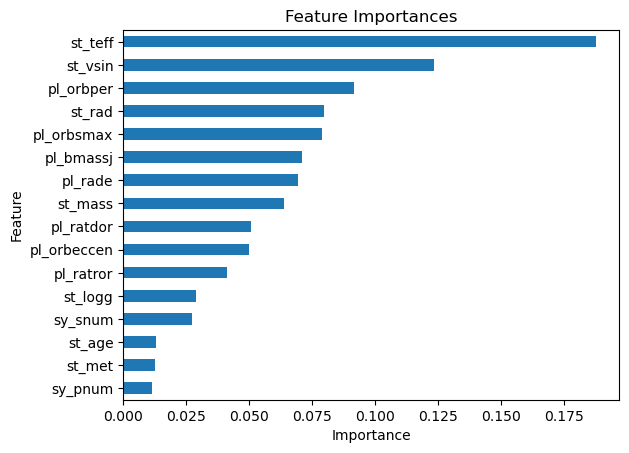

In [246]:
# Determine the most important parameters (features) in predicting obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/feature_importances_RF_attempt7.pdf'

direct_out = current_dir + '/results/RF_regression/plots'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

importances = rf_model.feature_importances_
all_feature_names = X_augmented_train.columns.to_list()
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot feature importances
top_n = len(all_feature_names)
feature_importances.head(top_n).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

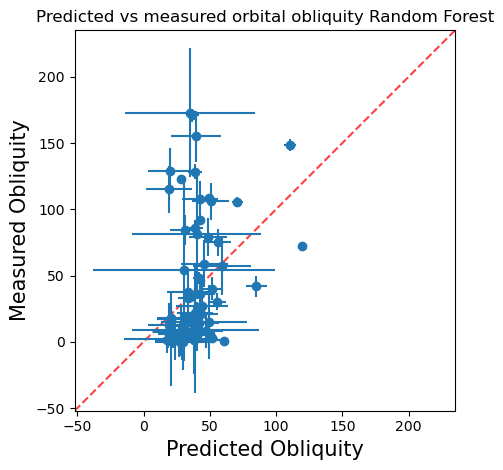

In [247]:
# Create a plot visualizing predicted obliquity vs actual obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/prediction_vs_measured_obliquity_RF_attempt7.pdf'

fig, ax = plt.subplots()
ax.errorbar(y_pred, y_test, xerr=y_test_err, yerr=y_test_err, fmt="o")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted Obliquity", fontsize=15)
ax.set_ylabel("Measured Obliquity", fontsize=15)
ax.set_title('Predicted vs measured orbital obliquity Random Forest')
fig.tight_layout()
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
filename = current_dir + '/results/RF_regression/plots' + '/decision_tree_RF_attempt7.pdf'

direct_out = current_dir + '/results/RF_regression/plots'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

# Visualizing one of the trees from the random forest
plt.figure(figsize=(15, 10))
plot_tree(rf_model.estimators_[0], feature_names=X_test.columns, filled=True, max_depth=3)
plt.title('Decision Tree Visualization (First Tree, max depth = 3)')
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

# Evaluate Random Forest Model using K-fold Cross Validation
Instead of creating two splits of the dataset, one for training and one for testing/validation, we will instead split the dataset into k number of subsets or folds. Then we will perform the training on all the subsets but leave one subset out for validation. We will do this k times, leaving a different subset out for validation. For our purposes, we will set k=10, i.e., a 10-fold cross validation. This seems to be the recommended size that should balance the trade off between high variance (when having only a few folds) and high bias (having many folds). Because of the data augmentation implemented here and not wanting to validate on augmented data, we cannot simply using the built-in cross validation functions but will have to create our own custom function.

In [248]:
# We need to create a custom function to produce the K-folds with data augmentation.
def custom_cross_validation(X, y, feature_uncertainty_map, y_err=None, pos_only=None, between_0_1=None, grt_1=None,
                            weights=None, num_folds=10, num_samples=10, seed=42):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    fold_results = []
    
    for train_index, test_index in kf.split(X):
        # Split the data into training and validation sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if y_err is not None and len(y_err) > 0:
            y_train_err, y_test_err = y_err.iloc[train_index], y_err.iloc[test_index]
        if weights is not None and len(weights) > 0:
            weights_train, weights_test = weights.iloc[train_index], weights.iloc[test_index]
        
        # Perform data augmentation only on the training set
        X_augmented_train, y_augmented_train, y_augmented_train_err, y_augmented_train_weights = augment_data_with_sampling(
            X_train,
            y_train,
            feature_uncertainty_map,
            y_err=y_train_err,
            pos_only=pos_only,
            between_0_1 = between_0_1,
            grt_1 = grt_1,
            weights=weights_train,
            num_samples=num_samples,
            seed=seed
        )

        # We need to drop the error columns as we won't be including them as features in the training and validations sets
        uncertainty_cols_test = [col for col in X_test.columns if col.endswith('_err')]
        X_test = X_test.drop(uncertainty_cols_test, axis=1)

        uncertainty_cols_train = [col for col in X_augmented_train.columns if col.endswith('_err')]
        X_augmented_train = X_augmented_train.drop(uncertainty_cols_train, axis=1)
        
        # Store the fold's training and validation data
        fold_results.append({
            'X_augmented_train': X_augmented_train,
            'y_augmented_train': y_augmented_train,
            'X_test': X_test,
            'y_test': y_test,
            'y_augmented_train_err': y_augmented_train_err,
            'y_augmented_train_weights': y_augmented_train_weights,
            'y_test_err': y_test_err,
            'weights_test': weights_test
        })
    
    return fold_results

In [249]:
# Set the random number generator seed
seed = 42
num_folds = 10
num_augmented_samples = 100
max_features = 'log2'

# Specify the features where only positive values, values between 0 and 1, and values larger than 1 should
# be generated.
pos_only = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'st_teff', 'st_rad',
            'st_mass', 'st_age', 'st_vsin']
# Values for ratio of the planet-to-star radius and orbital eccentricity should be between 0 and 1.
between_0_1 = ['pl_ratror', 'pl_orbeccen']
# Values for the ratio of the semi-major axis to stellar radius should always be greater than 1.
grt_1 = ['pl_ratdor']

X_preprocessed_df_copy = X_preprocessed_df.copy(deep=True)
uncertainty_cols = [col for col in X_preprocessed_df_copy.columns if col.endswith('_err')]
feature_uncertainty_map = {col.replace('_err', ''): col for col in uncertainty_cols}

# Get the K-fold data subsets for training and model evaluation.
data_folds = custom_cross_validation(
    X_preprocessed_df_copy,
    y_target,
    feature_uncertainty_map,
    y_err=y_target_err,
    pos_only=pos_only,
    between_0_1 = between_0_1,
    grt_1 = grt_1,
    weights=Obliquity_weights,
    num_folds=num_folds,
    num_samples=num_augmented_samples,
    seed=seed
)

In [250]:
# Train and evaluate random forest model using K-fold cross validation.
def RF_train_and_evaluate(data_folds, n_estimators=100, max_features=None, seed=42):

    fold_scores = {
        'mse': [],
        'rmse': [],
        'r2': []
    }

    fold_data = {
        'y_pred': [],
        'y_test': [],
        'y_test_err': []
    }
    
    for fold in tqdm(data_folds, desc='Training/Evaluating on Folds', leave=False):
        X_augmented_train = fold['X_augmented_train']
        y_augmented_train = fold['y_augmented_train']
        X_test = fold['X_test']
        y_test = fold['y_test']
        y_test_err = fold['y_test_err']
        y_augmented_train_weights = fold['y_augmented_train_weights']
        weights_test = fold['weights_test']
        
        # Initialize model with RandomForestRegressor
        rf_model_cv = RandomForestRegressor(n_estimators=n_estimators, random_state=seed, max_features=max_features)
        
        # Train the model on the augmented training data
        rf_model_cv.fit(X_augmented_train, y_augmented_train, sample_weight=y_augmented_train_weights)
        
        # Predict on the validation set
        y_pred = rf_model_cv.predict(X_test)

        fold_data['y_pred'].append(y_pred)
        fold_data['y_test'].append(y_test)
        fold_data['y_test_err'].append(y_test_err)
        
        # Calculate validation score (e.g., mean squared error)
        mse_score = mean_squared_error(y_test, y_pred, sample_weight=weights_test)
        rmse_score = np.sqrt(mse_score)
        r2 = r2_score(y_test, y_pred, sample_weight=weights_test)

        # Store the scores for this fold
        fold_scores['mse'].append(mse_score)
        fold_scores['rmse'].append(rmse_score)
        fold_scores['r2'].append(r2)
    
    # Return the validation score across all folds as well as test and predicted obliquities with errors.
    return(fold_scores, fold_data)

In [251]:
# Train and evaluate across all folds for the random forest model.
n_estimators = 200

fold_scores, fold_data = RF_train_and_evaluate(data_folds, n_estimators=n_estimators, max_features=max_features, seed=seed)

In [252]:
ave_mse_score = np.mean(fold_scores['mse'])
ave_rmse_score = np.mean(fold_scores['rmse'])
ave_r2_score = np.mean(fold_scores['r2'])

In [253]:
print('Maximum R² score: ', np.max(fold_scores['r2']))
print('Minimum R² score: ', np.min(fold_scores['r2']))
print('Median R² score: ', np.median(fold_scores['r2']))
print('Mean R² score: ', np.mean(fold_scores['r2']))
print('Variance in R² score: ', np.var(fold_scores['r2']))

Maximum R² score:  0.5345909568018141
Minimum R² score:  -1.4565612137514217
Median R² score:  0.1251884746639027
Mean R² score:  0.006698127036792489
Variance in R² score:  0.2964744879087863


In [254]:
print(f"Average Mean Squared Error Score (MSE): {ave_mse_score}")
print(f"Average Root Mean Squared Error Score (RMSE): {ave_rmse_score}")
print(f"Average R² Score: {ave_r2_score}")

Average Mean Squared Error Score (MSE): 1764.8995891489162
Average Root Mean Squared Error Score (RMSE): 39.5962861220426
Average R² Score: 0.006698127036792489


In [257]:
output_results_filename = current_dir + '/results/RF_regression/model_performance_results_RF_CV_attmept5.txt'

direct_out = current_dir + '/results/RF_regression'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

num_features_fit = len([col for col in X_preprocessed_df_copy.columns if not col.endswith('_err')])
features_fit_columns = [col for col in X_preprocessed_df_copy.columns if not col.endswith('_err')]
#print(features_fit_columns)

f = open(output_results_filename, "w")
f.write("Performance Results of Random Forest Model with K-Fold Cross Validation\n\n")
f.write(f"Average Mean Squared Error (MSE): {ave_mse_score:.2f}\n")
f.write(f"Average Root Mean Squared Error (RMSE): {ave_rmse_score:.2f}\n")
f.write(f"Average R² Score: {ave_r2_score:.2f}\n")
f.write(f"Median R² Score: {np.median(fold_scores['r2']):.2f}\n")
f.write(f"Minimum R² Score: {np.min(fold_scores['r2']):.2f}\n")
f.write(f"Maximum R² Score: {np.max(fold_scores['r2']):.2f}\n")
f.write(f"Variance in R² Scores: {np.var(fold_scores['r2']):.2f}\n")
f.write(f"Number of trees used in the model (n_estimators): {n_estimators:5d}\n")
f.write(f"Number of augmented samples: {num_augmented_samples:5d}\n")
f.write(f"Number of K-Folds: {num_folds:5d}\n")
f.write(f"Total number of features in model: {num_features_fit:5d}\n")
f.write(f"Maximum number of features to fit in model: {str(max_features):<5}\n")
f.write(f"Random number seed: {seed:5d}\n")
f.close()

In [258]:
def flatten_list(nested_list):
    return list(itertools.chain(*nested_list))

In [259]:
flat_y_pred_fold = flatten_list(fold_data['y_pred'])
flat_y_test_fold = flatten_list(fold_data['y_test'])
flat_y_test_err_fold = flatten_list(fold_data['y_test_err'])

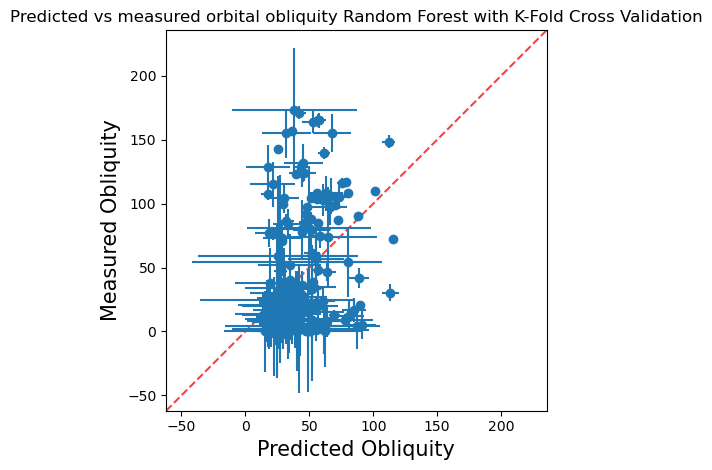

In [260]:
# Create a plot visualizing predicted obliquity vs actual obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/prediction_vs_measured_obliquity_RF_CV_attempt5.pdf'

fig, ax = plt.subplots()
ax.errorbar(flat_y_pred_fold, flat_y_test_fold, xerr=flat_y_test_err_fold, yerr=flat_y_test_err_fold, fmt="o")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted Obliquity", fontsize=15)
ax.set_ylabel("Measured Obliquity", fontsize=15)
ax.set_title('Predicted vs measured orbital obliquity Random Forest with K-Fold Cross Validation')
fig.tight_layout()
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

# Improving Random Forest Model
As demonstrated above, the random forest model unfortunately does not perform well in predicting obliquity. This could potentially be due to the relatively small sample size we are training on (while data augmentation should help, we are still training on mostly simulated data rather than actual data), the way we are handling missing data (data imputation using median values might not be the best strategy for every feature), other variables (features) that better explain the dependence on obliquity (maybe feature engineering can help), and/or random forest is not the best model to use or obliquity just doesn't have any strong dependencies on any measurable physical properties (e.g., strong dependence on migration but we can't measure migration per say a measurable feature to include in a model).

I will implement two strategies to hopefully improve the random forest model:
1) Instead of imputing missing values with just the median, the imputation strategy will be dependent on the feature in question. For example, if the mass of a star is missing but we have its effective temperature and radius, we can derive its mass using a physical model (equation) instead of using just the median value of the sample, which would be far less accurate. Another example, eccentricity, is typically close to 0 for short period planets but has a broader distribution for longer period planets. Therefore, we could replace missing eccentricity values for short period planets (say periods < 10 days) with the mean eccentricity value from the sample of planets with orbits of <10 days (short period sample) and the median eccentricity value from the sample of longer period planets for those planets with orbital periods >10 days with missing eccentricities.
   
2) It is possible obliquity has more significant dependencies on combinations of two properties (features) rather than the individual properties we have included in the model. Therefore, feature engineering might help us improve the model. One example of an engineered feature that will be tested is the ratio of the planet's mass to its host star mass (M<sub>p</sub>/M<sub>\*</sub>). There is a physical reason for using M<sub>p</sub>/M<sub>\*</sub> in that high obliquities might be dampened (orbits realigned) more easily for less massive planets in comparison to the mass of the host star. Another engineered feature is the bulk densities of the planets.

In [261]:
# Make a copy of the earlier dataframe storing the dataset
df_fit_new = df_fit.copy(deep=True)

# Specify the columns we will use as features, everything except 'Obliquity' and 'Obliquity_err' which are our target
# and target error, respectively.
feature_columns = [col for col in df_fit_new.columns if col not in ['Obliquity', 'Obliquity_err']]

# Separate features and target
X_features = df_fit_new[feature_columns]
y_target = df_fit_new['Obliquity']
y_target_err = df_fit_new['Obliquity_err']

# Specify columns we will handle missing values by hand. Order is important as some features depend on others.
special_features = ['st_teff', 'st_rad', 'st_mass', 'st_logg', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'pl_orbeccen', 
                    'pl_orbper', 'pl_ratdor', 'pl_ratror']
special_features_unc = [feature + '_err' for feature in special_features]

# Seperate out numerical and categorical features. In our case, there are only numerical features but I've kept this
# in case other features are added in the future.
numerical_cols = X_features.select_dtypes(include=['float64', 'int32']).columns.tolist()
categorical_cols = X_features.select_dtypes(include=['object']).columns.tolist()

X_features_numerical = X_features[numerical_cols]
X_features_categorical = X_features[categorical_cols]

uncertainty_cols = [col for col in X_features_numerical.columns if col.endswith('_err')]

# These are the remaining numerical features plus their associated uncertainties that will need median replacement of missing
# values.
other_features = [col for col in X_features_numerical.columns 
                  if col not in special_features or col not in special_features_unc]

# Define some constants for calculations
G_const = 6.6743e-11      # Gravitation constant, units: (N * m^2)/kg^2, where N is kg * m/s^2.
M_kg = 1.989e30           # Mass of the Sun in kg.
R_m = 6.957e8             # Radius of the Sun in meters.
AU_m = 1.496e11           # Number of meters in an AU.
pi = math.pi              # Value for Pi.
day_s = 86400.0           # Number of seconds in a day.
Jup_earth_mass = 317.906  # Jupiter to Earth masses, units: Earth masses
Jup_mass_kg = 1.899e27    # Mass of Jupiter in kg.
Jup_earth_radius = 11.209 # Jupiter to Earth radii, units: Earth radii
stefan_boltz = 5.67e-8    # The Stefan-Boltzmann constant, units: W * m^-2 * K^-4
Sol_lum = 3.86e26         # Luminosity of the Sun in watts.
Sol_temp = 5770.0         # Effective temperature of the Sun in K.
logg_sol = 4.437          # Logg of the sun.
g_sol = 10**4.437         # Sun's surface gravity in cm/s^2
alpha_constant = 6.85     # A constant used in the relation for calculating stellar ages, set to half the age of the universe.
Earth_radius_m = 6.378e6  # Radius of the Earth in meters.

# Keep track of how many missing values were replaced by calculated values or the median.
count_calc_replace = 0
count_median_replace = 0

for row in X_features_numerical.index.to_list():
    for feature in special_features:
        if pd.isna(X_features_numerical.loc[row, feature]):
            # Missing value for feature, let's handle it.
            # print('row: ', row)            

            # Orbital period is missing.
            if feature == 'pl_orbper':
                # Check if 'pl_orbsmax' and 'st_mass' are given, if so calculate orbital period and uncertainty.
                if pd.notna(X_features_numerical.loc[row, 'pl_orbsmax']) and pd.notna(X_features_numerical.loc[row, 'st_mass']):
                    orb_dist = X_features_numerical.loc[row, 'pl_orbsmax'] * AU_m
                    if pd.notna(X_features_numerical.loc[row, 'pl_orbsmax_err']):
                        orb_dist_err_ratio = (X_features_numerical.loc[row, 'pl_orbsmax_err'] * AU_m)/orb_dist
                    else:
                        orb_dist_err_ratio = ((df_fit_new['pl_orbsmax_err'].median()) * AU_m)/orb_dist
                    mass_kg = X_features_numerical.loc[row, 'st_mass'] * M_kg
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        mass_kg_err_ratio = (X_features_numerical.loc[row, 'st_mass_err'] * M_kg)/mass_kg
                    else:
                        mass_kg_err_ratio = (df_fit_new['st_mass_err'].median() * M_kg)/mass_kg
                    period_s = 2.0 * pi * math.sqrt((orb_dist**3.0)/(G_const * mass_kg))
                    period_s_err = math.sqrt(((3.0/2.0)*orb_dist_err_ratio)**2.0 + (0.5*mass_kg_err_ratio)**2.0) * period_s
                    period_day = period_s/day_s
                    period_day_err = period_s_err/day_s
                    X_features_numerical.loc[row, 'pl_orbper'] = period_day
                    X_features_numerical.loc[row, 'pl_orbper_err'] = period_day_err
                    # print('Calculated orbital period: ', period_day)
                    # print('Calculated orbital period error: ', period_day_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the required parameters to derive period, use median value instead.
                    X_features_numerical.loc[row, 'pl_orbper'] = df_fit_new['pl_orbper'].median()
                    X_features_numerical.loc[row, 'pl_orbper_err'] = df_fit_new['pl_orbper_err'].median()
                    # print('Median orbital period: ', df_fit_new['pl_orbper'].median())
                    # print('Median orbital period error: ', df_fit_new['pl_orbper_err'].median())
                    count_median_replace = count_median_replace + 1

            # Planet radius is missing.
            if feature == 'pl_rade':
                # If the planet mass is given, we will calculate it based on the mass-radius relation of Muller et al. 2024.
                if pd.notna(X_features_numerical.loc[row, 'pl_bmassj']):
                    mass_earth = X_features_numerical.loc[row, 'pl_bmassj'] * Jup_earth_mass
                    if pd.notna(X_features_numerical.loc[row, 'pl_bmassj_err']):
                        mass_earth_err = X_features_numerical.loc[row, 'pl_bmassj_err'] * Jup_earth_mass
                    else:
                        mass_earth_err = (df_fit_new['pl_bmassj_err'].median()) * Jup_earth_mass
                    mass_err_ratio = mass_earth_err/mass_earth
                    if mass_earth <= 4.37:
                        radius_earth = 1.02 * mass_earth**(0.27)
                        radius_earth_err = mass_err_ratio * radius_earth
                    elif mass_earth > 4.37 and mass_earth <= 127:
                        radius_earth = 0.56 * mass_earth**(0.67)
                        radius_earth_err = mass_err_ratio * radius_earth
                    else: 
                        radius_earth = 18.6 * mass_earth**(-0.06)
                        radius_earth_err = mass_err_ratio * radius_earth
                    X_features_numerical.loc[row, 'pl_rade'] = radius_earth
                    X_features_numerical.loc[row, 'pl_rade_err'] = radius_earth_err
                    # print('Calculated planet radius: ', radius_earth)
                    # print('Calculated planet radius error: ', radius_earth_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the planet mass to derive the radius, use median value instead.
                    X_features_numerical.loc[row, 'pl_rade'] = df_fit_new['pl_rade'].median()
                    X_features_numerical.loc[row, 'pl_rade_err'] = df_fit_new['pl_rade_err'].median()
                    # print('Median planet radius: ', df_fit_new['pl_rade'].median())
                    # print('Median planet radius error: ', df_fit_new['pl_rade_err'].median())
                    count_median_replace = count_median_replace + 1

            # Planet mass is missing.
            if feature == 'pl_bmassj':
                # If the planet radius is given, we will calculate it based on the mass-radius relation of Muller et al. 2024.
                if pd.notna(X_features_numerical.loc[row, 'pl_rade']):
                    radius_earth = X_features_numerical.loc[row, 'pl_rade']
                    if pd.notna(X_features_numerical.loc[row, 'pl_rade_err']):
                        radius_earth_err = X_features_numerical.loc[row, 'pl_rade_err']
                    else:
                        radius_earth_err = df_fit_new['pl_rade_err'].median()
                    radius_err_ratio = radius_earth_err/radius_earth
                    if radius_earth <= 1.52:
                        mass_earth = (radius_earth/1.02)**(3.7)
                        mass_jup = mass_earth/Jup_earth_mass
                        mass_jup_err = radius_err_ratio * mass_jup
                    elif radius_earth > 1.52 and radius_earth <= 11.0:
                        mass_earth = (radius_earth/0.56)**(1.49)
                        mass_jup = mass_earth/Jup_earth_mass
                        mass_jup_err = radius_err_ratio * mass_jup
                    else:
                        # Note, there is a break in the mass-radius relation at 120 Earth masses or just less than the radius of
                        # Jupiter, planets more massive than this actually decrease in radius slightly as the mass increases,
                        # therefore, it's better to use the median mass value for planets larger than 11 Earth radii.
                        filt_df = df_fit_new[df_fit_new['pl_rade'] > 11.0]
                        mass_jup = filt_df['pl_bmassj'].median()
                        mass_jup_err = filt_df['pl_bmassj_err'].median()
                    X_features_numerical.loc[row, 'pl_bmassj'] = mass_jup
                    X_features_numerical.loc[row, 'pl_bmassj_err'] = mass_jup_err
                    # print('Calculated planet mass: ', mass_jup)
                    # print('Calculated planet mass error: ', mass_jup_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the planet radius to derive the mass, use median value instead.
                    X_features_numerical.loc[row, 'pl_bmassj'] = df_fit_new['pl_bmassj'].median()
                    X_features_numerical.loc[row, 'pl_bmassj_err'] = df_fit_new['pl_bmassj_err'].median()
                    # print('Median planet radius: ', df_fit_new['pl_bmassj'].median())
                    # print('Median planet radius error: ', df_fit_new['pl_bmassj_err'].median())
                    count_median_replace = count_median_replace + 1

            # Eccentricity is missing.
            if feature == 'pl_orbeccen':
                # If the planet orbital period is given, we set the eccentricity as the variance of either the short period planets,
                # period <= 10 days, or the median eccentricity of the long period planets, period > 10 days. Short period planets
                # should have eccentricities close to zero while longer period planets have higher eccentricities.
                if pd.notna(X_features_numerical.loc[row, 'pl_orbper']):
                    planet_period = X_features_numerical.loc[row, 'pl_orbper']
                    if planet_period <= 10.0:
                        # Short period planets, use variance as eccentricity value. For the error, use the same value.
                        filt_df = df_fit_new[df_fit_new['pl_orbper'] <= 10.0]
                        ecc_value = filt_df['pl_orbeccen'].var()
                        ecc_value_err = filt_df['pl_orbeccen'].var()
                    else:
                        # Long period planets, use median as eccentricity and variance for the error.
                        filt_df = df_fit_new[df_fit_new['pl_orbper'] > 10.0]
                        ecc_value = filt_df['pl_orbeccen'].median()
                        ecc_value_err = filt_df['pl_orbeccen'].var()
                    X_features_numerical.loc[row, 'pl_orbeccen'] = ecc_value
                    X_features_numerical.loc[row, 'pl_orbeccen_err'] = ecc_value_err
                    # print('Calculated eccentricity: ', ecc_value)
                    # print('Calculated eccentricity error: ', ecc_value_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the orbital period, will use mean value of entire sample instead and variance for the error.
                    X_features_numerical.loc[row, 'pl_orbeccen'] = df_fit_new['pl_orbeccen'].mean()
                    X_features_numerical.loc[row, 'pl_orbeccen_err'] = df_fit_new['pl_orbeccen_err'].var()
                    # print('Mean eccentricity: ', df_fit_new['pl_orbeccen'].mean())
                    # print('Mean eccentricity error: ', df_fit_new['pl_orbeccen_err'].var())
                    count_median_replace = count_median_replace + 1

            # Stellar effective temperature is missing.
            if feature == 'st_teff':
                # If the stellar mass is known, the luminosity of the star can be determined using the mass-luminosity relation
                # (assuming the star is a main sequence star) which in turn can be used to determine the effective temperature.
                # If the stellar radius instead of the mass is known, we can convert the stellar radius to mass and then use the
                # mass-luminosity relation to get the luminosity and then effective temperature.
                if pd.notna(X_features_numerical.loc[row, 'st_mass']) and pd.notna(X_features_numerical.loc[row, 'st_rad']):
                    # Have both the stellar mass and radius.
                    star_mass = X_features_numerical.loc[row, 'st_mass']
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        star_mass_err_ratio = X_features_numerical.loc[row, 'st_mass_err']/star_mass
                    else:
                        star_mass_err_ratio = (df_fit_new['st_mass_err'].median())/star_mass
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    if star_mass <= 0.43:
                        lum_solar = 0.23 * star_mass**(2.3)
                    elif star_mass > 0.43 and star_mass <= 2.0:
                        lum_solar = star_mass**(4.0)
                    else:
                        lum_solar = 1.4 * star_mass**(3.5)
                    star_temp = ((lum_solar*Sol_lum)/(4.0*pi*(star_radius*R_m)**(2.0)*stefan_boltz))**(0.25)
                    star_temp_err = math.sqrt(((0.25)*star_mass_err_ratio)**(2.0) + ((0.5)*star_radius_err_ratio)**(2.0)) * star_temp
                    # print('Calculated effective temperature 1: ', star_temp)
                    # print('Calculated effective temperature error 1: ', star_temp_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.notna(X_features_numerical.loc[row, 'st_mass']) and pd.isna(X_features_numerical.loc[row, 'st_rad']):
                    # Have the stellar mass, but not the radius. Find radius first from mass-radius relation.
                    star_mass = X_features_numerical.loc[row, 'st_mass']
                    star_radius = star_mass**0.8
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        star_mass_err = X_features_numerical.loc[row, 'st_mass_err']
                        star_radius_err = X_features_numerical.loc[row, 'st_mass_err']**0.8
                    else:
                        star_mass_err = df_fit_new['st_mass_err'].median()
                        star_radius_err = (df_fit_new['st_mass_err'].median())**0.8
                    star_mass_err_ratio = star_mass_err/star_mass
                    star_radius_err_ratio = star_radius_err/star_radius
                    if star_mass <= 0.43:
                        lum_solar = 0.23 * star_mass**(2.3)
                    elif star_mass > 0.43 and star_mass <= 2.0:
                        lum_solar = star_mass**(4.0)
                    else:
                        lum_solar = 1.4 * star_mass**(3.5)
                    star_temp = ((lum_solar*Sol_lum)/(4.0*pi*(star_radius*R_m)**(2.0)*stefan_boltz))**(0.25)
                    star_temp_err = math.sqrt(((0.25)*star_mass_err_ratio)**(2.0) + ((0.5)*star_radius_err_ratio)**(2.0)) * star_temp
                    # print('Calculated effective temperature 2: ', star_temp)
                    # print('Calculated effective temperature error 2: ', star_temp_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.isna(X_features_numerical.loc[row, 'st_mass']) and pd.notna(X_features_numerical.loc[row, 'st_rad']):
                    # Have the stellar radius, but not the mass. Find mass first from mass-radius relation.
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    star_mass = star_radius**1.25
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err = X_features_numerical.loc[row, 'st_rad_err']
                        star_mass_err = X_features_numerical.loc[row, 'st_rad_err']**1.25
                    else:
                        star_radius_err = df_fit_new['st_rad_err'].median()
                        star_mass_err = (df_fit_new['st_rad_err'].median())**1.25
                    star_radius_err_ratio = star_radius_err/star_radius
                    star_mass_err_ratio = star_mass_err/star_mass
                    if star_mass <= 0.43:
                        lum_solar = 0.23 * star_mass**(2.3)
                    elif star_mass > 0.43 and star_mass <= 2.0:
                        lum_solar = star_mass**(4.0)
                    else:
                        lum_solar = 1.4 * star_mass**(3.5)
                    star_temp = ((lum_solar*Sol_lum)/(4.0*pi*(star_radius*R_m)**(2.0)*stefan_boltz))**(0.25)
                    star_temp_err = math.sqrt(((0.25)*star_mass_err_ratio)**(2.0) + ((0.5)*star_radius_err_ratio)**(2.0)) * star_temp
                    # print('Calculated effective temperature 3: ', star_temp)
                    # print('Calculated effective temperature error 3: ', star_temp_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the stellar mass or radius, will replace missing effective temperature of the sample.
                    star_temp = df_fit_new['st_teff'].median()
                    star_temp_err = df_fit_new['st_teff_err'].median()
                    # print('Median effective temperature: ', star_temp)
                    # print('Median effective temperature error: ', star_temp_err)
                    count_median_replace = count_median_replace + 1

                X_features_numerical.loc[row, 'st_teff'] = star_temp
                X_features_numerical.loc[row, 'st_teff_err'] = star_temp_err

            # Stellar radius is missing.
            if feature == 'st_rad':
                # If the stellar mass and effective temperature are known, the radius of the star can be determined using the
                # mass-luminosity relation and then using Stefan-Boltzmann law to calculate the stellar radius from the luminosity
                # and effective temperature, assuming the star is a main sequence star.
                # If the stellar mass is known but not the effective temperature, the radius can be estimated from the simple 
                # mass-radius relation R~M^0.8.
                # If the effective temperature is given but not the mass, then we will make the very simple approximation:
                # R/R_sun = Teff/Teff_sun.
                if pd.notna(X_features_numerical.loc[row, 'st_mass']) and pd.notna(X_features_numerical.loc[row, 'st_teff']):
                    # Have both the stellar mass and effective temperature.
                    star_mass = X_features_numerical.loc[row, 'st_mass']
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        star_mass_err_ratio = X_features_numerical.loc[row, 'st_mass_err']/star_mass
                    else:
                        star_mass_err_ratio = (df_fit_new['st_mass_err'].median())/star_mass
                    star_temp = X_features_numerical.loc[row, 'st_teff']
                    if pd.notna(X_features_numerical.loc[row, 'st_teff_err']):
                        star_temp_err_ratio = X_features_numerical.loc[row, 'st_teff_err']/star_temp
                    else:
                        star_temp_err_ratio = (df_fit_new['st_teff_err'].median())/star_temp
                    if star_mass <= 0.43:
                        lum_solar = 0.23 * star_mass**(2.3)
                    elif star_mass > 0.43 and star_mass <= 2.0:
                        lum_solar = star_mass**(4.0)
                    else:
                        lum_solar = 1.4 * star_mass**(3.5)
                    star_radius = math.sqrt((lum_solar*Sol_lum)/(4.0*pi*star_temp**(4.0)*stefan_boltz))/R_m
                    star_radius_err = math.sqrt(((0.5)*star_mass_err_ratio)**(2.0) + ((2.0)*star_temp_err_ratio)**(2.0)) * star_radius
                    # print('Calculated stellar radius 1: ', star_radius)
                    # print('Calculated stellar radius error 1: ', star_radius_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.notna(X_features_numerical.loc[row, 'st_mass']) and pd.isna(X_features_numerical.loc[row, 'st_teff']):
                    # Have the stellar mass, but not the effective temperature. Find radius from the mass-radius relation.
                    star_mass = X_features_numerical.loc[row, 'st_mass']
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        star_mass_err_ratio = X_features_numerical.loc[row, 'st_mass_err']/star_mass
                    else:
                        star_mass_err_ratio = (df_fit_new['st_mass_err'].median())/star_mass
                    star_radius = star_mass**0.8
                    star_radius_err = star_mass_err_ratio * star_radius
                    # print('Calculated stellar radius 2: ', star_radius)
                    # print('Calculated stellar radius error 2: ', star_radius_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.isna(X_features_numerical.loc[row, 'st_mass']) and pd.notna(X_features_numerical.loc[row, 'st_teff']):
                    # Have the stellar effective temperature, but not the mass. We will use a simple radius-temperature relation.
                    star_temp = X_features_numerical.loc[row, 'st_teff']
                    if pd.notna(X_features_numerical.loc[row, 'st_teff_err']):
                        star_temp_err_ratio = X_features_numerical.loc[row, 'st_teff_err']/star_temp
                    else:
                        star_temp_err_ratio = (df_fit_new['st_teff_err'].median())/star_temp
                    star_radius = star_temp/Sol_temp
                    # Uncertainties in the Teff are generally quite small. Need to scale to use as uncertainties is stellar radius.
                    star_radius_err = 4.0*(star_temp_err_ratio * star_radius)
                    # print('Calculated stellar radius 3: ', star_radius)
                    # print('Calculated stellar radius error 3: ', star_radius_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the stellar mass or effective temperature, will replace missing radius of the sample.
                    star_radius = df_fit_new['st_rad'].median()
                    star_radius_err = df_fit_new['st_rad_err'].median()
                    # print('Median stellar radius: ', star_temp)
                    # print('Median stellar radius error: ', star_temp_err)
                    count_median_replace = count_median_replace + 1

                X_features_numerical.loc[row, 'st_rad'] = star_radius
                X_features_numerical.loc[row, 'st_rad_err'] = star_radius_err

            # Stellar mass is missing.
            if feature == 'st_mass':
                # If the stellar radius and effective temperature are known, the luminosity of the star can be calculated from
                # the stefan-Boltzmann equation and then the mass can be determined via the mass-luminosity relation.
                # If the stellar radius is known but not the effective temperature, the mass can be estimated from the simple 
                # mass-radius M~R^1.25.
                # If the effective temperature is given but not the radius, then we will make the very simple approximation:
                # M/M_sun = (Teff/Teff_sun)^1.14, assuming a main sequence star.
                if pd.notna(X_features_numerical.loc[row, 'st_rad']) and pd.notna(X_features_numerical.loc[row, 'st_teff']):
                    # Have both the stellar radius and effective temperature.
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    star_radius_m = star_radius * R_m
                    star_temp = X_features_numerical.loc[row, 'st_teff']
                    if pd.notna(X_features_numerical.loc[row, 'st_teff_err']):
                        star_temp_err_ratio = X_features_numerical.loc[row, 'st_teff_err']/star_temp
                    else:
                        star_temp_err_ratio = (df_fit_new['st_teff_err'].median())/star_temp
                    stellar_lum = 4.0 * pi * star_radius_m**(2.0) * stefan_boltz * star_temp**(4.0)
                    lum_solar = stellar_lum/Sol_lum
                    lum_solar_err_ratio = math.sqrt(((2.0)*star_radius_err_ratio)**(2.0) + ((4.0)*star_temp_err_ratio)**(2.0))
                    if lum_solar <= 0.033:
                        star_mass = (lum_solar/0.23)**(0.435)
                    elif lum_solar > 0.033 and lum_solar <= 16.0:
                        star_mass = lum_solar**(0.25)
                    else:
                        star_mass = (lum_solar/1.4)**(0.286)
                    star_mass_err = lum_solar_err_ratio * star_mass
                    # print('Calculated stellar mass 1: ', star_mass)
                    # print('Calculated stellar mass error 1: ', star_mass_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.notna(X_features_numerical.loc[row, 'st_rad']) and pd.isna(X_features_numerical.loc[row, 'st_teff']):
                    # Have the stellar radius, but not the effective temperature. Find mass from the mass-radius relation.
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    star_mass = star_radius**1.25
                    star_mass_err = star_radius_err_ratio * star_mass
                    # print('Calculated stellar mass 2: ', star_mass)
                    # print('Calculated stellar mass error 2: ', star_mass_err)
                    count_calc_replace = count_calc_replace + 1
                elif pd.isna(X_features_numerical.loc[row, 'st_rad']) and pd.notna(X_features_numerical.loc[row, 'st_teff']):
                    # Have the stellar effective temperature, but not the radius. We will use a simple mass-temperature relation.
                    star_temp = X_features_numerical.loc[row, 'st_teff']
                    if pd.notna(X_features_numerical.loc[row, 'st_teff_err']):
                        star_temp_err_ratio = X_features_numerical.loc[row, 'st_teff_err']/star_temp
                    else:
                        star_temp_err_ratio = (df_fit_new['st_teff_err'].median())/star_temp
                    star_mass = (star_temp/Sol_temp)**(1.14)
                    # Uncertainties in the Teff are generally quite small. Need to scale to use as uncertainties for stellar mass.
                    star_mass_err = 4.0*(star_temp_err_ratio * star_mass)
                    # print('Calculated stellar mass 3: ', star_mass)
                    # print('Calculated stellar mass error 3: ', star_mass_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the stellar radius or effective temperature, will replace missing mass of the sample.
                    star_mass = df_fit_new['st_mass'].median()
                    star_mass_err = df_fit_new['st_mass_err'].median()
                    # print('Median stellar mass: ', star_mass)
                    # print('Median stellar mass error: ', star_mass_err)
                    count_median_replace = count_median_replace + 1

                X_features_numerical.loc[row, 'st_mass'] = star_mass
                X_features_numerical.loc[row, 'st_mass_err'] = star_mass_err
            
            # Stellar logg is missing.
            if feature == 'st_logg':
                # If the stellar mass and radius are known, then logg can be calculated easily via:
                # log(g) = log(g)_sol + log(M) - 2log(R).
                # If the stellar mass and radius are not known, then use median of sample.
                if pd.notna(X_features_numerical.loc[row, 'st_mass']) and pd.notna(X_features_numerical.loc[row, 'st_rad']):
                    # Have both the stellar mass and radius.
                    star_mass = X_features_numerical.loc[row, 'st_mass']
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        star_mass_err_ratio = X_features_numerical.loc[row, 'st_mass_err']/star_mass
                    else:
                        star_mass_err_ratio = (df_fit_new['st_mass_err'].median())/star_mass
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    star_logg = logg_sol + math.log10(star_mass) - 2.0*math.log(star_radius)
                    star_logg_err = math.sqrt(star_mass_err_ratio**(2.0) + (2.0*star_radius_err_ratio)**2.0) * star_logg
                    # print('Calculated logg: ', star_logg)
                    # print('Calculated logg error: ', star_logg_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the stellar mass or radius, will replace missing logg with median of the sample.
                    star_logg = df_fit_new['st_logg'].median()
                    star_logg_err = df_fit_new['st_logg_err'].median()
                    # print('Median stellar logg: ', star_logg)
                    # print('Median stellar logg error: ', star_logg_err)
                    count_median_replace = count_median_replace + 1

                X_features_numerical.loc[row, 'st_logg'] = star_logg
                X_features_numerical.loc[row, 'st_logg_err'] = star_logg_err

            # Stellar age is missing.
            if feature == 'st_age':
                # If the stellar logg and temperature are known, then the age can be calculated using the empirical relation:
                # Age ~ alpha * (T_sol/T_star)^4 * (g_sol/g_star)^1.5.
                # If the stellar logg and temperature are not known, then use median of sample.
                if pd.notna(X_features_numerical.loc[row, 'st_logg']) and pd.notna(X_features_numerical.loc[row, 'st_teff']):
                    # Have both the stellar logg and temperature.
                    g_star = 10.0**(X_features_numerical.loc[row, 'st_logg'])
                    if pd.notna(X_features_numerical.loc[row, 'st_logg_err']):
                        g_star_err_ratio = (10.0**(X_features_numerical.loc[row, 'st_logg_err']))/g_star
                    else:
                        g_star_err_ratio = (10.0**(df_fit_new['st_logg_err'].median()))/g_star
                    star_temp = X_features_numerical.loc[row, 'st_teff']
                    if pd.notna(X_features_numerical.loc[row, 'st_teff_err']):
                        star_temp_err_ratio = X_features_numerical.loc[row, 'st_teff_err']/star_temp
                    else:
                        star_temp_err_ratio = (df_fit_new['st_teff_err'].median())/star_temp
                    star_age = alpha_constant * (Sol_temp/star_temp)**(4.0) * (g_sol/g_star)**(1.5)
                    # Inflate uncertainties by a factor of 4.
                    star_age_err = 4.0*(math.sqrt((4.0*star_temp_err_ratio)**(2.0) + (1.5*g_star_err_ratio)**2.0) * star_age)
                    # print('logg: ', X_features_numerical.loc[row, 'st_logg'])
                    if star_age > df_fit_new['st_age'].median():
                        # star ages should be less than the age of the universe and most likely will be much younger than
                        # that. If the age is above the median age of the sample, it is likely not very trustworthy so
                        # just use median instead.
                        star_age = df_fit_new['st_age'].median()
                        star_age_err = df_fit_new['st_age_err'].median()
                    # print('Calculated age: ', star_age)
                    # print('Calculated age error: ', star_age_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the stellar logg or temperature, will replace missing age with median of the sample.
                    star_age = df_fit_new['st_age'].median()
                    star_age_err = df_fit_new['st_age_err'].median()
                    # print('Median stellar age: ', st_age)
                    # print('Median stellar age error: ', st_age_err)
                    count_median_replace = count_median_replace + 1

                X_features_numerical.loc[row, 'st_age'] = star_age
                X_features_numerical.loc[row, 'st_age_err'] = star_age_err

            # Semi major axis is missing.
            if feature == 'pl_orbsmax':
                # Check if 'pl_orbper' and 'st_mass' are given, if so calculate semi major axis and uncertainty.
                if pd.notna(X_features_numerical.loc[row, 'pl_orbper']) and pd.notna(X_features_numerical.loc[row, 'st_mass']):
                    period_s = X_features_numerical.loc[row, 'pl_orbper'] * day_s
                    if pd.notna(X_features_numerical.loc[row, 'pl_orbper_err']):
                        period_s_err = X_features_numerical.loc[row, 'pl_orbper_err'] * day_s
                    else:
                        period_s_err = (df_fit_new['pl_orbper_err'].median()) * day_s
                    mass_kg = X_features_numerical.loc[row, 'st_mass'] * M_kg
                    if pd.notna(X_features_numerical.loc[row, 'st_mass_err']):
                        mass_kg_err = X_features_numerical.loc[row, 'st_mass_err'] * M_kg
                    else:
                        mass_kg_err = (df_fit_new['st_mass_err'].median()) * M_kg
                    a_dist_m = ((G_const * mass_kg * period_s**2.0)/(4.0 * pi**2.0))**(1.0/3.0)
                    a_dist_m_err = math.sqrt((((1.0/3.0)*mass_kg_err)/mass_kg)**2.0 +\
                                             (((2.0/3.0)*period_s_err)/period_s)**2.0) * a_dist_m
                    a_dist_AU = a_dist_m/AU_m
                    a_dist_AU_err = a_dist_m_err/AU_m
                    X_features_numerical.loc[row, 'pl_orbsmax'] = a_dist_AU
                    X_features_numerical.loc[row, 'pl_orbsmax_err'] = a_dist_AU_err
                    # print('Calculated semi major axis: ', a_dist_AU)
                    # print('Calculated semi major axis error: ', a_dist_AU_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the required parameters to derive semi major axis, use median value instead.
                    X_features_numerical.loc[row, 'pl_orbsmax'] = df_fit_new['pl_orbsmax'].median()
                    X_features_numerical.loc[row, 'pl_orbsmax_err'] = df_fit_new['pl_orbsmax_err'].median()
                    # print('Median semi major axis: ', df_fit_new['pl_orbsmax'].median())
                    # print('Median semi major axis error: ', df_fit_new['pl_orbsmax_err'].median())
                    count_median_replace = count_median_replace + 1

            # a/R* is missing.
            if feature == 'pl_ratdor':
                # a/R* can be easily calculated if the semi major axis and stellar radius is given. Otherwise use median value
                # from sample
                if pd.notna(X_features_numerical.loc[row, 'pl_orbsmax']) and pd.notna(X_features_numerical.loc[row, 'st_rad']):
                    a_dist_AU = X_features_numerical.loc[row, 'pl_orbsmax']
                    if pd.notna(X_features_numerical.loc[row, 'pl_orbsmax_err']):
                        a_dist_err_ratio = X_features_numerical.loc[row, 'pl_orbsmax_err']/a_dist_AU
                    else:
                        a_dist_err_ratio = (df_fit_new['pl_orbsmax_err'].median())/a_dist_AU
                    a_dist_m = a_dist_AU * AU_m
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    star_radius_m = star_radius * R_m
                    a_Rs = a_dist_m/star_radius_m
                    a_Rs_err = math.sqrt(a_dist_err_ratio**(2.0) + star_radius_err_ratio**(2.0)) * a_Rs
                    X_features_numerical.loc[row, 'pl_ratdor'] = a_Rs
                    X_features_numerical.loc[row, 'pl_ratdor_err'] = a_Rs_err
                    # print('Calculated a/R*: ', a_Rs)
                    # print('Calculated a/R* error: ', a_Rs_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the semi major axis or stellar radius, use median value instead.
                    X_features_numerical.loc[row, 'pl_ratdor'] = df_fit_new['pl_ratdor'].median()
                    X_features_numerical.loc[row, 'pl_ratdor_err'] = df_fit_new['pl_ratdor_err'].median()
                    # print('Median a/R*: ', df_fit_new['pl_ratdor'].median())
                    # print('Median a/R* error: ', df_fit_new['pl_ratdor_err'].median())
                    count_median_replace = count_median_replace + 1

            # Rp/R* is missing.
            if feature == 'pl_ratror':
                # Rp/R* can be easily calculated if the planet radius and stellar radius is given. Otherwise use median value
                # from sample
                if pd.notna(X_features_numerical.loc[row, 'pl_rade']) and pd.notna(X_features_numerical.loc[row, 'st_rad']):
                    planet_radius = X_features_numerical.loc[row, 'pl_rade']
                    if pd.notna(X_features_numerical.loc[row, 'pl_rade_err']):
                        planet_radius_err_ratio = X_features_numerical.loc[row, 'pl_rade_err']/planet_radius
                    else:
                        planet_radius_err_ratio = (df_fit_new['pl_rade_err'].median())/planet_radius
                    planet_radius_m = planet_radius * Earth_radius_m
                    star_radius = X_features_numerical.loc[row, 'st_rad']
                    if pd.notna(X_features_numerical.loc[row, 'st_rad_err']):
                        star_radius_err_ratio = X_features_numerical.loc[row, 'st_rad_err']/star_radius
                    else:
                        star_radius_err_ratio = (df_fit_new['st_rad_err'].median())/star_radius
                    star_radius_m = star_radius * R_m
                    Rp_Rs = planet_radius_m/star_radius_m
                    Rp_Rs_err = math.sqrt(planet_radius_err_ratio**(2.0) + star_radius_err_ratio**(2.0)) * Rp_Rs
                    X_features_numerical.loc[row, 'pl_ratror'] = Rp_Rs
                    X_features_numerical.loc[row, 'pl_ratror_err'] = Rp_Rs_err
                    # print('Calculated Rp/R*: ', Rp_Rs)
                    # print('Calculated Rp/R* error: ', Rp_Rs_err)
                    count_calc_replace = count_calc_replace + 1
                else:
                    # Don't have the planet radius or stellar radius, use median value instead.
                    X_features_numerical.loc[row, 'pl_ratror'] = df_fit_new['pl_ratror'].median()
                    X_features_numerical.loc[row, 'pl_ratror_err'] = df_fit_new['pl_ratror_err'].median()
                    # print('Median Rp/R*: ', df_fit_new['pl_ratror'].median())
                    # print('Median Rp/R* error: ', df_fit_new['pl_ratror_err'].median())
                    count_median_replace = count_median_replace + 1

# Now replace missing values in all the other numerical columns with the median value of that column.
for col in other_features:
    median_value = df_fit_new[col].median()
    X_features_numerical.fillna({col: median_value}, inplace=True)

In [262]:
if len(categorical_cols) > 0:

    # Impute missing categorical values with 'most_frequent'
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Fit and transform the categorical data
    X_features_categorical_imputed = categorical_pipeline.fit_transform(X_features_categorical)

    # Convert the one-hot encoded array back into a DataFrame
    categorical_encoded_cols = categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_cols)
    X_features_categorical_encoded = pd.DataFrame(X_features_categorical_imputed, columns=categorical_encoded_cols)
    
    # Combine the numerical and encoded categorical features into one DataFrame
    X_preprocessed_df = pd.concat([X_features_numerical, X_features_categorical_encoded], axis=1)
else:
    # If no categorical features exist, just use the numerical features
    X_preprocessed_df = X_features_numerical.copy()

In [263]:
print(X_preprocessed_df.head())

   sy_snum  sy_pnum  pl_orbper  pl_orbper_err  pl_orbsmax  pl_orbsmax_err  \
0        2        5   0.736547       0.000001    0.015440        0.000050   
1        1        3   6.267910       0.000430    0.069000        0.003000   
2        1        3   8.462999       8.462999    0.064500        0.001300   
3        1        1   1.508956       0.000006    0.025312        0.001332   
4        2        1   1.742994       0.000001    0.027980        0.000780   

     pl_rade  pl_rade_err  pl_bmassj  pl_bmassj_err  ...  st_mass  \
0   1.875000     0.029000    0.02514       0.001025  ...     0.91   
1   1.430200     0.130018    0.01100       0.001000  ...     1.10   
2   4.184742     0.342118    0.06330       0.005175  ...     0.50   
3  16.700000     0.900000    1.03000       0.120000  ...     0.95   
4  16.432000     0.482000    3.47000       0.220000  ...     0.96   

   st_mass_err  st_met  st_met_err   st_logg  st_logg_err  st_age  st_age_err  \
0         0.01    0.35        0.10  4.430

In [265]:
# To improve the model further, it might be worth engineering new features that may correlate more strongly
# with obliquity. One feature we will engineer is the ratio of planet mass to stellar mass (Mp/M*).
# Another feature is the planet bulk density.
X_preprocessed_df['pl_ratmom'] = (X_preprocessed_df['pl_bmassj']*Jup_mass_kg)/(X_preprocessed_df['st_mass']*M_kg)
X_preprocessed_df['pl_ratmom_err'] = np.sqrt((X_preprocessed_df['pl_bmassj_err'] / X_preprocessed_df['pl_bmassj'])**2 + 
                                             (X_preprocessed_df['st_mass_err'] / X_preprocessed_df['st_mass'])**2) * \
                                              X_preprocessed_df['pl_ratmom']

# Planet density in g/cm^3
X_preprocessed_df['pl_density'] = (X_preprocessed_df['pl_bmassj']*Jup_mass_kg*1000.0)\
                                  /((4.0/3.0)*pi*(X_preprocessed_df['pl_rade']*Earth_radius_m*100.0)**(3.0))
X_preprocessed_df['pl_density_err'] = np.sqrt((X_preprocessed_df['pl_bmassj_err'] / X_preprocessed_df['pl_bmassj'])**2 + 
                                             ((1.0/3.0)*(X_preprocessed_df['pl_rade_err'] / X_preprocessed_df['pl_rade']))**2) * \
                                              X_preprocessed_df['pl_density']

In [266]:
print('Here are the feature columns we will be training the model on: ', X_preprocessed_df.columns.to_list())

dataframe_preprocessed_filename_out = current_dir + '/' + data_input + \
                                      '/preprocessed_feat_eng_obliquity_planet_stellar_properties_' + current_date + '.csv'
X_preprocessed_df.to_csv(dataframe_preprocessed_filename_out, index=False)

Here are the feature columns we will be training the model on:  ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbper_err', 'pl_orbsmax', 'pl_orbsmax_err', 'pl_rade', 'pl_rade_err', 'pl_bmassj', 'pl_bmassj_err', 'pl_orbeccen', 'pl_orbeccen_err', 'pl_ratdor', 'pl_ratdor_err', 'pl_ratror', 'pl_ratror_err', 'st_teff', 'st_teff_err', 'st_rad', 'st_rad_err', 'st_mass', 'st_mass_err', 'st_met', 'st_met_err', 'st_logg', 'st_logg_err', 'st_age', 'st_age_err', 'st_vsin', 'st_vsin_err', 'pl_ratmom', 'pl_ratmom_err', 'pl_density', 'pl_density_err']


In [267]:
# Before we apply data augmentation using the uncertainties on the data points, we need to split the data into
# training and testing datasets. The reason for this is that we want to train on an augmented dataset but
# validate (test) on a non-augmented dataset. Therefore, we need to split the dataset between training and
# testing before we do data augmentation. Validating on an augmented (simulated) dataset is not correct and
# can skew model performance matrics.

# Set the random number generator seed
seed = 42
test_size=0.30

# Split the dataset into training and testing sets before augmentation.
X_train, X_test, y_train, y_test, y_train_err, y_test_err, weights_train, weights_test = train_test_split(
    X_preprocessed_df,
    y_target,
    y_target_err,
    Obliquity_weights,
    test_size=test_size,
    random_state=seed,
    shuffle=True
)

# Remove uncertainty columns in testing dataset.
uncertainty_cols_test = [col for col in X_test.columns if col.endswith('_err')]
X_test.drop(uncertainty_cols_test, axis=1, inplace=True)

In [268]:
# Specify the features where only positive values, values between 0 and 1, and values larger than 1 should
# be generated.
pos_only = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'st_teff', 'st_rad',
            'st_mass', 'st_age', 'st_vsin', 'pl_density']
# Values for ratio of the planet-to-star radius, mass, and orbital eccentricity should be between 0 and 1.
between_0_1 = ['pl_ratror', 'pl_orbeccen', 'pl_ratmom']
# Values for the ratio of the semi-major axis to stellar radius should always be greater than 1.
grt_1 = ['pl_ratdor']

In [269]:
# Now, we'll perform data augmentation by generating multiple samples for each data point based on their uncertainties.

# Define the number of augmented samples per original sample. Not sure how large this should be, start with 10.
num_augmented_samples = 100

# Identify features with associated uncertainties
# These are columns ending with '_err'
uncertainty_cols_train = [col for col in X_train.columns if col.endswith('_err')]

# Map each uncertainty column to its corresponding feature
# For example, 'pl_orbper_err' corresponds to 'pl_orbper'
feature_uncertainty_map = {col.replace('_err', ''): col for col in uncertainty_cols_train}

# Perform data augmentation
X_augmented_train, y_augmented_train, y_augmented_train_err, y_augmented_train_weights = augment_data_with_sampling(
    X_train,
    y_train,
    feature_uncertainty_map,
    y_err=y_train_err,
    pos_only=pos_only,
    between_0_1 = between_0_1,
    grt_1 = grt_1,
    weights=weights_train,
    num_samples=num_augmented_samples,
    seed=seed
)

In [270]:
# With the augmented dataset ready, let's train and evaluate the Random Forest model with the physically derived
# missing values and new features.

# First drop the error columns in the training set as we will not be training the RF model
# on those columns.
uncertainty_cols_train = [col for col in X_augmented_train.columns if col.endswith('_err')]
X_augmented_train.drop(uncertainty_cols_train, axis=1, inplace=True)

n_estimators = 1000
max_features = 'log2'
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=seed, max_features=max_features)

# Train the model
rf_model.fit(X_augmented_train, y_augmented_train, sample_weight=y_augmented_train_weights)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, sample_weight=weights_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred, sample_weight=weights_test)

print(f"Random Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Random Forest Model Performance:
Mean Squared Error (MSE): 1222.61
Root Mean Squared Error (RMSE): 34.97
R² Score: 0.23


In [271]:
output_results_filename = current_dir + '/results/RF_regression/model_performance_results_derived_eng_RF_attmept2.txt'

direct_out = current_dir + '/results/RF_regression'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

num_features_fit = len([col for col in X_preprocessed_df.columns if not col.endswith('_err')])

f = open(output_results_filename, "w")
f.write("Performance Results of Random Forest Model with Physically Derived Missing Values and Engineered Features\n\n")
f.write(f"Mean Squared Error (MSE): {mse:.2f}\n")
f.write(f"Root Mean Squared Error (RMSE): {rmse:.2f}\n")
f.write(f"R² Score: {r2:.2f}\n")
f.write(f"Number of trees used in the model (n_estimators): {n_estimators:5d}\n")
f.write(f"Number of augmented samples: {num_augmented_samples:5d}\n")
f.write(f"Total number of features in model: {num_features_fit:5d}\n")
f.write(f"Maximum number of features to fit in model: {str(max_features):<5}\n")
f.write(f"Test size fraction: {test_size:.2f}\n")
f.close()

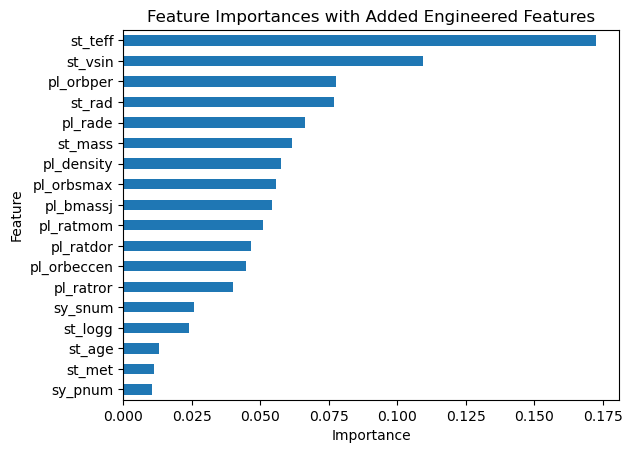

In [272]:
# Determine the most important parameters (features) in predicting obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/feature_importances_derived_eng_RF_attempt2.pdf'

direct_out = current_dir + '/results/RF_regression/plots'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

importances = rf_model.feature_importances_
all_feature_names = X_augmented_train.columns.to_list()
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot feature importances
top_n = len(all_feature_names)
feature_importances.head(top_n).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Feature Importances with Added Engineered Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

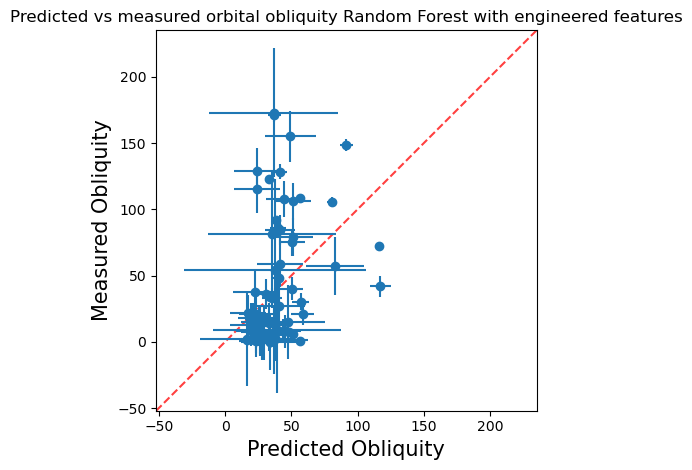

In [273]:
# Create a plot visualizing predicted obliquity vs actual obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/prediction_vs_measured_obliquity_derived_eng_RF_attempt2.pdf'

fig, ax = plt.subplots()
ax.errorbar(y_pred, y_test, xerr=y_test_err, yerr=y_test_err, fmt="o")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted Obliquity", fontsize=15)
ax.set_ylabel("Measured Obliquity", fontsize=15)
ax.set_title('Predicted vs measured orbital obliquity Random Forest with engineered features')
fig.tight_layout()
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
filename = current_dir + '/results/RF_regression/plots' + '/decision_tree_derived_eng_RF_attempt2.pdf'

direct_out = current_dir + '/results/RF_regression/plots'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

# Visualizing one of the trees from the random forest
plt.figure(figsize=(15, 10))
plot_tree(rf_model.estimators_[0], feature_names=X_test.columns, filled=True, max_depth=3)
plt.title('Decision Tree Visualization (First Tree, max depth = 3)')
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

# Evaluate Random Forest Model using K-fold Cross Validation with the Engineered Features
We will perform K-fold cross validation, but now using the dataset where missing values were physically derived and one or more features were engineered. Let's see if the model performs better with these changes.

In [274]:
# Set the random number generator seed
seed = 42
num_folds = 10
num_augmented_samples = 100

# Specify the features where only positive values, values between 0 and 1, and values larger than 1 should
# be generated.
pos_only = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmassj', 'st_teff', 'st_rad',
            'st_mass', 'st_age', 'st_vsin', 'pl_density']
# Values for ratio of the planet-to-star radius, mass, and orbital eccentricity should be between 0 and 1.
between_0_1 = ['pl_ratror', 'pl_orbeccen', 'pl_ratmom']
# Values for the ratio of the semi-major axis to stellar radius should always be greater than 1.
grt_1 = ['pl_ratdor']

X_preprocessed_df_copy = X_preprocessed_df.copy(deep=True)
uncertainty_cols = [col for col in X_preprocessed_df_copy.columns if col.endswith('_err')]
feature_uncertainty_map = {col.replace('_err', ''): col for col in uncertainty_cols}

# Get the K-fold data subsets for training and model evaluation.
data_folds = custom_cross_validation(
    X_preprocessed_df_copy,
    y_target,
    feature_uncertainty_map,
    y_err=y_target_err,
    pos_only=pos_only,
    between_0_1 = between_0_1,
    grt_1 = grt_1,
    weights=Obliquity_weights,
    num_folds=num_folds,
    num_samples=num_augmented_samples,
    seed=seed
)

In [289]:
# One important tunable parameter is the max_features, which controls the maximum number of features to use when
# looking for the best split at each node in the RF model. Here I perform a simple grid search to find the most
# optimal value to use.
num_features_fit = len([col for col in X_preprocessed_df_copy.columns if not col.endswith('_err')])
n_estimators = 200

num_features_grid = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 'sqrt', 'log2', 0.1, 0.05]
num_feat_vs_r2_score = []
for max_features in tqdm(num_features_grid, desc='Number Features Grid'):
    fold_scores, fold_data = RF_train_and_evaluate(data_folds, n_estimators=n_estimators, max_features=max_features, seed=seed)
    ave_r2_score = np.mean(fold_scores['r2'])
    med_r2_score = np.median(fold_scores['r2'])
    num_feat_vs_r2_score.append((max_features, ave_r2_score, med_r2_score))

In [291]:
print(num_feat_vs_r2_score)

best_result = max(num_feat_vs_r2_score, key=lambda x: x[2])

print('Best result: ', best_result)

[(1.0, -0.16153233369267356, 0.032756508943624474), (0.9, -0.0870548643354092, 0.022460658464256933), (0.8, -0.04787134245286599, 0.07683389688970249), (0.7, -0.00705106608441638, 0.14222422083658076), (0.6, 0.031050490631959648, 0.16599984240920557), (0.5, 0.008066100847361323, 0.13673971399104995), (0.4, 0.022805022169108367, 0.15622069547291878), (0.3, 0.0037130099123826145, 0.1708265135300403), ('sqrt', 0.021493928400747042, 0.1816698103209468), ('log2', 0.021493928400747042, 0.1816698103209468), (0.1, -0.06035057258560813, 0.02739373753002844)]
Best result:  ('sqrt', 0.021493928400747042, 0.1816698103209468)


In [275]:
# Train and evaluate across all folds for the random forest model.
# Choose the best setting of max features based on the above results.
n_estimators = 200
max_features = 'log2'

fold_scores, fold_data = RF_train_and_evaluate(data_folds, n_estimators=n_estimators, max_features=max_features, seed=seed)

In [276]:
ave_mse_score = np.mean(fold_scores['mse'])
ave_rmse_score = np.mean(fold_scores['rmse'])
ave_r2_score = np.mean(fold_scores['r2'])

In [277]:
print('Maximum R² score: ', np.max(fold_scores['r2']))
print('Minimum R² score: ', np.min(fold_scores['r2']))
print('Median R² score: ', np.median(fold_scores['r2']))
print('Mean R² score: ', np.mean(fold_scores['r2']))
print('Variance in R² score: ', np.var(fold_scores['r2']))
print(f"Average Mean Squared Error Score (MSE): {ave_mse_score}")
print(f"Average Root Mean Squared Error Score (RMSE): {ave_rmse_score}")
print(f"Average R² Score: {ave_r2_score}")

Maximum R² score:  0.7322674965496149
Minimum R² score:  -1.495674135989947
Median R² score:  0.1816698103209468
Mean R² score:  0.021493928400747042
Variance in R² score:  0.324396510743688
Average Mean Squared Error Score (MSE): 1702.118569652553
Average Root Mean Squared Error Score (RMSE): 38.77653292659477
Average R² Score: 0.021493928400747042


In [278]:
output_results_filename = current_dir + '/results/RF_regression/model_performance_results_derived_eng_RF_CV_attmept2.txt'

direct_out = current_dir + '/results/RF_regression'

if not os.path.exists(direct_out):
    os.makedirs(direct_out)

f = open(output_results_filename, "w")
f.write("Performance Results of Random Forest Model with K-Fold Cross Validation with Engineered Features\n\n")
f.write(f"Average Mean Squared Error (MSE): {ave_mse_score:.2f}\n")
f.write(f"Average Root Mean Squared Error (RMSE): {ave_rmse_score:.2f}\n")
f.write(f"Average R² Score: {ave_r2_score:.2f}\n")
f.write(f"Median R² Score: {np.median(fold_scores['r2']):.2f}\n")
f.write(f"Minimum R² Score: {np.min(fold_scores['r2']):.2f}\n")
f.write(f"Maximum R² Score: {np.max(fold_scores['r2']):.2f}\n")
f.write(f"Variance in R² Scores: {np.var(fold_scores['r2']):.2f}\n")
f.write(f"Number of trees used in the model (n_estimators): {n_estimators:5d}\n")
f.write(f"Number of augmented samples: {num_augmented_samples:5d}\n")
f.write(f"Number of K-Folds: {num_folds:5d}\n")
f.write(f"Total number of features in model: {num_features_fit:5d}\n")
f.write(f"Maximum number of features to fit in model: {str(max_features):<5}\n")
f.write(f"Random number seed: {seed:5d}\n")
f.close()

In [279]:
flat_y_pred_fold = flatten_list(fold_data['y_pred'])
flat_y_test_fold = flatten_list(fold_data['y_test'])
flat_y_test_err_fold = flatten_list(fold_data['y_test_err'])

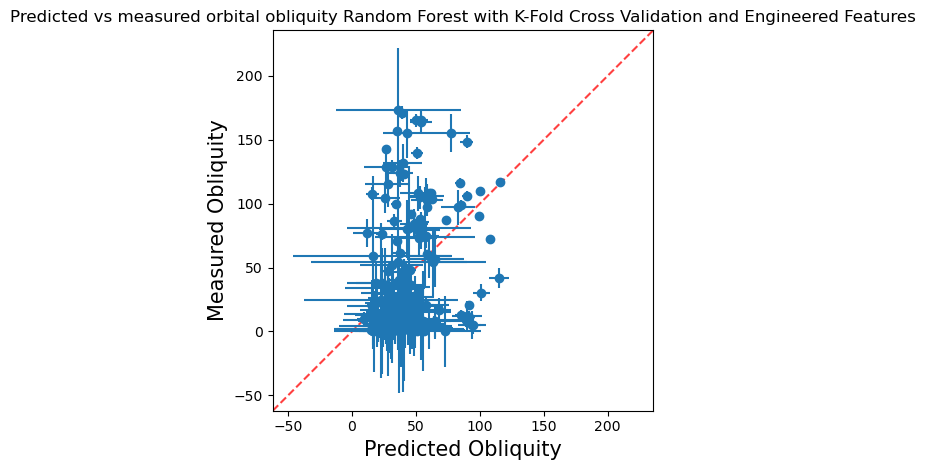

In [280]:
# Create a plot visualizing predicted obliquity vs actual obliquity.
filename = current_dir + '/results/RF_regression/plots' + '/prediction_vs_measured_obliquity_derived_eng_RF_CV_attempt2.pdf'

fig, ax = plt.subplots()
ax.errorbar(flat_y_pred_fold, flat_y_test_fold, xerr=flat_y_test_err_fold, yerr=flat_y_test_err_fold, fmt="o")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted Obliquity", fontsize=15)
ax.set_ylabel("Measured Obliquity", fontsize=15)
ax.set_title('Predicted vs measured orbital obliquity Random Forest with K-Fold Cross Validation and Engineered Features')
fig.tight_layout()
plt.savefig(filename, format="pdf", bbox_inches="tight")
plt.show()

In [281]:
# Let's explore the correlations between the planet and stellar properties (features) and obliquity,
# given that the random forest model is performing poorly. To do this, we will be calculating
# weighted Pearson and Spearman correlations between the various parameters and obliquity along with
# their p-values to assess the statistical significance of the correlations.

# The Pearson correlation is a measure of the strength and direction of the linear relationship
# between a feature and target. Similarly, the Spearman correlation also measures the strength
# and direction of the relationship between a feature and target that is monotonic (not necessarily
# linear such as in the case of Pearson).

# The p-values computed here gives the likelihood of obtaining the correlation between the feature and target 
# at least as extreme as what is actually observed, under the assumption that no correlation exist between
# the feature and target (null hypothesis) is correct.

# Function to compute weighted Pearson and Spearman correlations and p-values, incorporating the uncertainties
# in the features and target (obliquity).
def weighted_corr_and_pvalue(x, y, weights_x, weights_y):
    # Combine weights by multiplying weights_x and weights_y to incorporate the uncertainties in the features
    # and the target.
    combined_weights = weights_x * weights_y
    
    # Compute weighted averages for x and y
    avg_x = np.average(x, weights=combined_weights)
    avg_y = np.average(y, weights=combined_weights)

    # Compute weighted covariance and variances
    var_x = np.average((x - avg_x)**2, weights=combined_weights)
    var_y = np.average((y - avg_y)**2, weights=combined_weights)

    # Check if variance is too small (constant values)
    if var_x < 1.0e-10 or var_y < 1e-10:
        return 0.0, 1.0  # No correlation for near-constant values

    cov_xy = np.average((x - avg_x) * (y - avg_y), weights=combined_weights)

    # Compute the weighted Pearson correlation
    r = cov_xy / np.sqrt(var_x * var_y)

    # # Clamp r to avoid values very close to 1 or -1
    # r = np.clip(r, -0.9999, 0.9999)

    # Calculate the effective sample size
    neff = np.sum(combined_weights)**2 / np.sum(combined_weights**2)

    if neff < 2 or np.isnan(neff) or np.isnan(r):
        print('neff: ', neff)
        print('r: ', r)
        print('median combined_weights: ', combined_weights.median())
        print('minimum combined_weights: ', combined_weights.min())
        print('maximum combined_weights: ', combined_weights.max())
        print('var_x: ', var_x)
        print('var_y: ', var_y)

    # Check if neff is greater than 2
    if neff > 2:
        # Calculate t-statistic and p-value
        try:
            t_stat = r * np.sqrt((neff - 2.0) / (1.0 - r**2.0))
            p_value = 2.0 * (1.0 - stats.t.cdf(abs(t_stat), df=neff - 2.0))
        except ValueError:
            t_stat = np.nan
            p_value = np.nan
    else:
        t_stat = np.nan
        p_value = np.nan
    
    return r, p_value

In [282]:
# Function to calculate weighted correlations and p-values
def calculate_weighted_correlations_with_pvalues(X, y, X_uncertainties, y_uncertainties):
    columns = X.columns
    pearson_corr = pd.DataFrame(index=columns, columns=['Weighted Pearson'])
    pearson_pvalues = pd.DataFrame(index=columns, columns=['p-value'])
    spearman_corr = pd.DataFrame(index=columns, columns=['Weighted Spearman'])
    spearman_pvalues = pd.DataFrame(index=columns, columns=['p-value'])

    for col in columns:
        x_values = X[col]
        
        # Check if the feature has uncertainties; if not, assign equal weights
        if col in X_uncertainties.columns:
            x_err = X_uncertainties[col]
            weights_x = 1.0 / (x_err**2.0)
        else:
            weights_x = np.ones_like(x_values)  # Equal weights for features without uncertainties
        
        # Target weights based on uncertainties
        weights_y = 1.0 / (y_uncertainties**2.0)

        # Weighted Pearson correlation and p-value
        pearson_corr_value, pearson_p_value = weighted_corr_and_pvalue(x_values, y, weights_x, weights_y)
        pearson_corr.loc[col, 'Weighted Pearson'] = pearson_corr_value
        pearson_pvalues.loc[col, 'p-value'] = pearson_p_value

        # Weighted Spearman correlation and p-value (using ranks)
        ranks_x = x_values.rank()
        ranks_y = y.rank()
        spearman_corr_value, spearman_p_value = weighted_corr_and_pvalue(ranks_x, ranks_y, weights_x, weights_y)
        spearman_corr.loc[col, 'Weighted Spearman'] = spearman_corr_value
        spearman_pvalues.loc[col, 'p-value'] = spearman_p_value

    return pearson_corr, pearson_pvalues, spearman_corr, spearman_pvalues

In [283]:
# Replace 0 uncertainties in X_uncertainties with the median of the non-zero values for each feature.
# Uncertainty of zero is problematic when calculating weighted correlations and p-values.
def replace_zero_uncertainties_with_median(X_uncertainties):
    for col in X_uncertainties.columns:
        non_zero_values = X_uncertainties[col][X_uncertainties[col] > 0.0]
        if len(non_zero_values) > 0.0:  # Only replace if there are non-zero values to compute the median
            median_value = non_zero_values.median()
            X_uncertainties[col] = X_uncertainties[col].replace(0.0, median_value)
    return X_uncertainties

In [284]:
# Create new dataframes for the uncertainties for the planet/stellar properties and obliquity
X_uncertainties = X_preprocessed_df_copy.filter(like='_err').copy(deep=True)

# Apply the function to replace zero uncertainties in X_uncertainties
X_uncertainties_cleaned = replace_zero_uncertainties_with_median(X_uncertainties)

y_uncertainties = y_target_err.copy(deep=True)  # Target uncertainties

# Drop the uncertainty columns from the features for correlation computation
X_features_corr = X_preprocessed_df_copy.drop(columns=X_uncertainties_cleaned.columns).copy(deep=True)

# Compute weighted Pearson and Spearman correlations and p-values
weighted_pearson_corr, weighted_pearson_pvalues, weighted_spearman_corr, weighted_spearman_pvalues = \
    calculate_weighted_correlations_with_pvalues(
    X_features_corr, y_target, X_uncertainties_cleaned, y_uncertainties
)

In [285]:
# Loop through each column in the dataframe to find any values of 0 in the feature uncertainties.
for column in X_uncertainties_cleaned.columns:
    # Find the row indices where the value is zero in the current column
    zero_rows = X_uncertainties_cleaned[X_uncertainties_cleaned[column] == 0.0].index
    
    # Check if there are any rows with zero values
    if not zero_rows.empty:
        total_zeros = len(zero_rows)
        print(f"Column: {column} has {total_zeros} rows with zero values")
        for row in zero_rows:
            print(f"Row: {row}, Column: {column} has a zero value")
        print("\n")  # Add a newline for better readability between columns

In [286]:
# Function to create the Pearson/Spearman correlation heatmaps with the p-value statistical
# significance.
def annotate_heatmap_with_pvalues(corr_df, pval_df, title, corr_type, filename):

    # Make sure that both correlation and p-value dataframes have the same shape
    assert corr_df.shape == pval_df.shape, "Correlation and p-value dataframes must have the same shape!"
    
    annotate_list = []
    combined_data_str = []
    for i in range(len(corr_df)):
        # Round and convert both correlation and p-value dataframes to strings
        corr_str = corr_df.iloc[i,0].round(3).astype(str)
        pval_str = pval_df.iloc[i,0].round(3).astype(str)
        annotate_list.append((corr_str, pval_str))
        combined_data_str.append(corr_str + " (p-value=" + pval_str + ")")

    combined_data_df = pd.DataFrame(combined_data_str, index=corr_df.index)
    # print('combined_data_df: ', combined_data_df)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    if corr_type == 'Pearson':
        sns.heatmap(corr_df.astype(float), annot=combined_data_df.values, fmt="", cmap="coolwarm",
                    cbar_kws={'label': 'Linear Correlation'})
    elif corr_type == 'Spearman':
        sns.heatmap(corr_df.astype(float), annot=combined_data_df.values, fmt="", cmap="coolwarm",
                    cbar_kws={'label': 'Monotonic Correlation'})
    else:
        sns.heatmap(corr_df.astype(float), annot=combined_data_df.values, fmt="", cmap="coolwarm",
                    cbar_kws={'label': 'Other Correlation'})
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

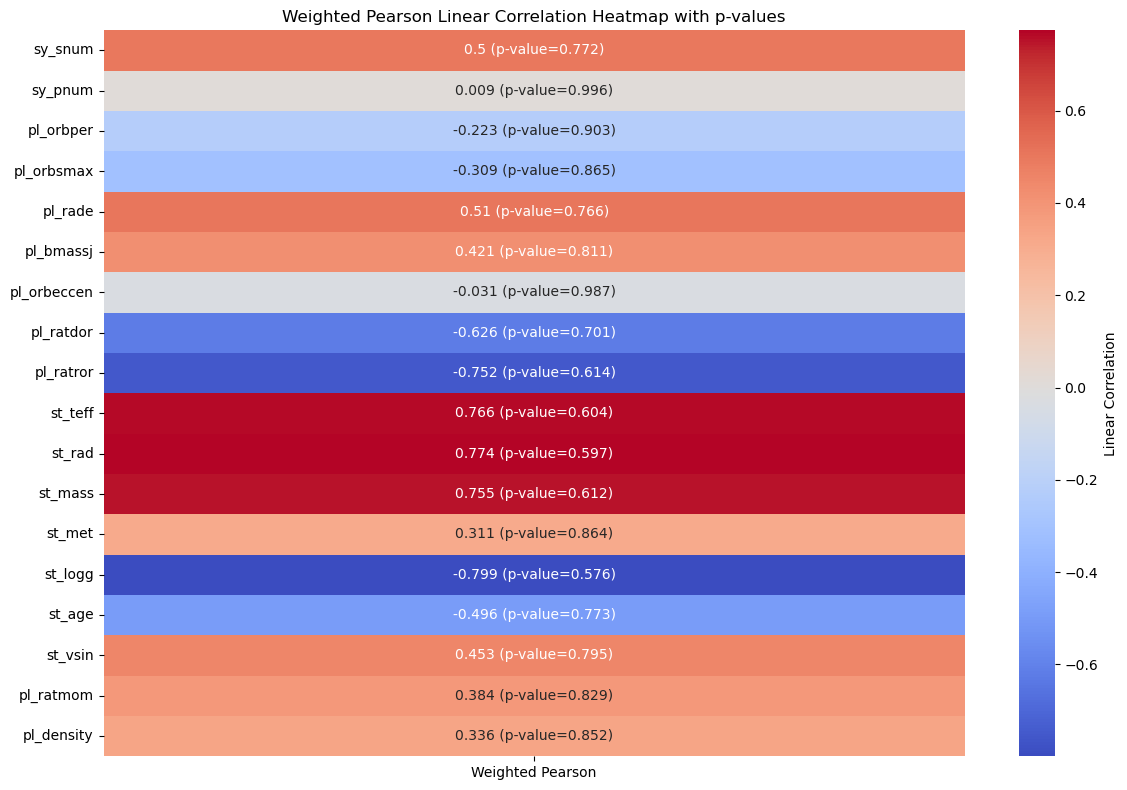

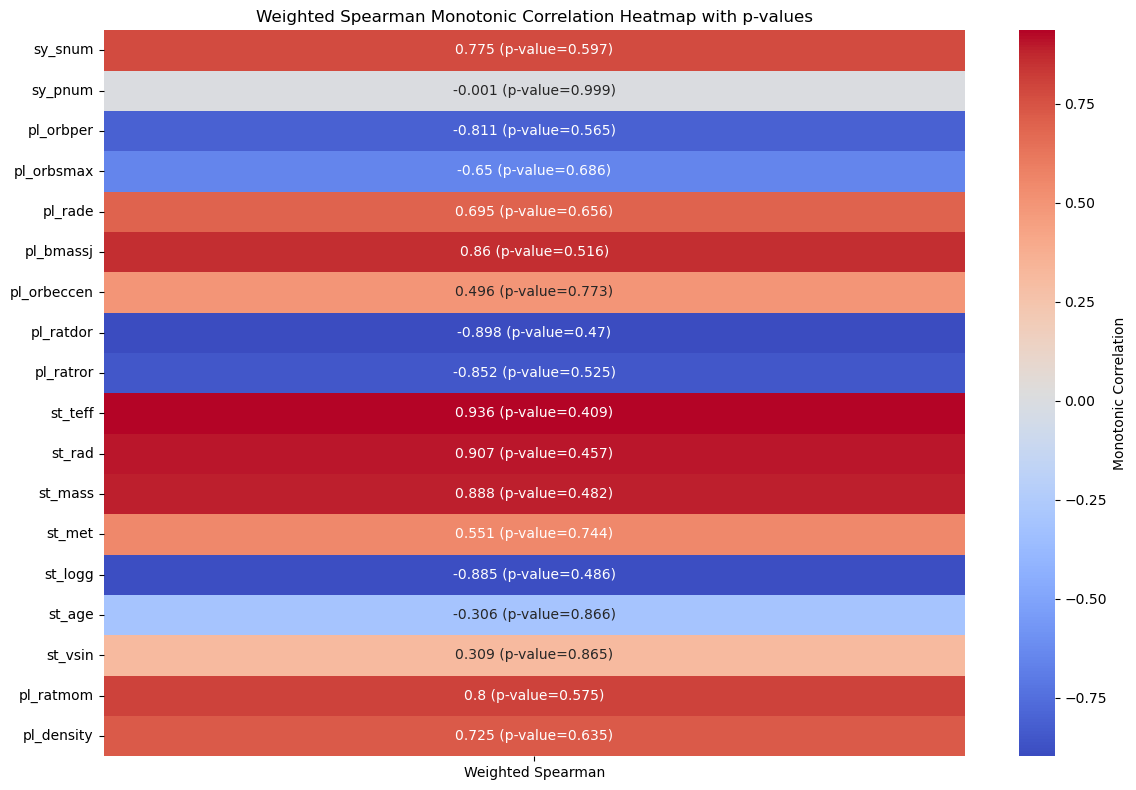

In [287]:
# Plot weighted Pearson correlation heatmap with p-values
filename = current_dir + '/exploratory_plots' + '/pearson_correlation_heatmap.pdf'
annotate_heatmap_with_pvalues(weighted_pearson_corr, weighted_pearson_pvalues,
                              'Weighted Pearson Linear Correlation Heatmap with p-values',
                              'Pearson', filename)

# Plot weighted Spearman correlation heatmap with p-values
filename = current_dir + '/exploratory_plots' + '/spearman_correlation_heatmap.pdf'
annotate_heatmap_with_pvalues(weighted_spearman_corr, weighted_spearman_pvalues,
                              'Weighted Spearman Monotonic Correlation Heatmap with p-values',
                              'Spearman', filename)

# Obliquity shows weak correlations
Based on the Pearson and Spearman correlation heatmaps, it appears that the correlations between the stellar/planetary parameters and obliquity are not statistically significant. This could explain why the random forest model is performing poorly in predicting obliquity based on the model features. Additionally, the sample size is less than 230 systems, which is likely too small for the random forest model to make any meaningful predictions on obliquity (even with data augmentation). A Bayesian based approach that appropriately incorporates the uncertainties on the stellar and planetary parameters as well as on obliquity might yield better results, though likely not significantly better. I will explore other machine learning models on this dataset in another Jupyter Notebook.